In [1]:
from PIL import Image
import sys
import os

def get_png_dimensions(file_path):
    if not file_path.lower().endswith('.png'):
        raise ValueError(f"File {file_path} is not a PNG file.")
    try:
        with Image.open(file_path) as img:
            return img.size  # returns (width, height)
    except Exception as e:
        print(f"Failed to read {file_path}: {e}")
        return None

dimensions = get_png_dimensions("./snicket/data/train/midjourney/0000.png")
if dimensions:
    print(f"Dimensions: {dimensions[0]}x{dimensions[1]}")

Dimensions: 256x256


In [2]:
# Score: 88.7
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm

train_dir = "snicket/data/train"
val_dir   = "snicket/data/val"

batch_size = 32
num_epochs = 5
learning_rate = 1e-4
num_classes = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                             std=[0.229,0.224,0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                             std=[0.229,0.224,0.225])
    ]),
}

train_dataset = datasets.ImageFolder(os.path.join(train_dir), transform=data_transforms['train'])
val_dataset   = datasets.ImageFolder(os.path.join(val_dir),   transform=data_transforms['val'  ])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=4)

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([7000/2000, 7000/5000]).to(device))
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [train]"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch} train loss: {epoch_loss:.4f}")

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{num_epochs} [val]"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total * 100
    print(f"Epoch {epoch} val accuracy: {val_acc:.2f}%\n")

torch.save(model.state_dict(), "midjourney_vs_nature_resnet18-equal.pth")
print("Training complete. Model saved to midjourney_vs_nature_resnet18.pth")


KeyboardInterrupt: 

In [ ]:
# Score: 91.3

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from tqdm import tqdm
from collections import Counter

train_dir = "snicket/data/train"
val_dir   = "snicket/data/val"

batch_size    = 32
num_epochs    = 10
learning_rate = 1e-4
num_classes   = 2
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                             std=[0.229,0.224,0.225]),
        transforms.RandomErasing(p=0.5, scale=(0.02,0.33), ratio=(0.3,3.3), value='random'),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                             std=[0.229,0.224,0.225]),
    ]),
}

train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset   = datasets.ImageFolder(val_dir,   transform=data_transforms['val'])

counts = Counter([label for _, label in train_dataset.imgs]) 
total = sum(counts.values())
class_weights = {cls: total/count for cls, count in counts.items()}
sample_weights = [class_weights[label] for _, label in train_dataset.imgs]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=sampler,
    num_workers=4
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4
)

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

weights = torch.tensor([total/counts[0], total/counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=2
)

for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [train]"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch} train loss: {train_loss:.4f}")

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{num_epochs} [val]"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / len(val_loader.dataset)
    val_acc = correct / total * 100
    print(f"Epoch {epoch} val loss: {val_loss:.4f}, val accuracy: {val_acc:.2f}%")

    scheduler.step(val_loss)
    print()

torch.save(model.state_dict(), "midjourney_vs_nature_resnet18-improved.pth")
print("Training complete. Model saved to midjourney_vs_nature_resnet18-improved.pth")


Epoch 1/10 [train]: 100%|██████████| 220/220 [04:19<00:00,  1.18s/it]


Epoch 1 train loss: 0.3736


Epoch 1/10 [val]: 100%|██████████| 32/32 [00:11<00:00,  2.69it/s]


Epoch 1 val loss: 0.4248, val accuracy: 82.60%



Epoch 2/10 [train]: 100%|██████████| 220/220 [04:00<00:00,  1.09s/it]


Epoch 2 train loss: 0.2555


Epoch 2/10 [val]: 100%|██████████| 32/32 [00:10<00:00,  2.94it/s]


Epoch 2 val loss: 0.4356, val accuracy: 83.00%



Epoch 3/10 [train]: 100%|██████████| 220/220 [03:58<00:00,  1.09s/it]


Epoch 3 train loss: 0.2025


Epoch 3/10 [val]: 100%|██████████| 32/32 [00:11<00:00,  2.86it/s]


Epoch 3 val loss: 0.3939, val accuracy: 85.20%



Epoch 4/10 [train]: 100%|██████████| 220/220 [03:58<00:00,  1.08s/it]


Epoch 4 train loss: 0.1728


Epoch 4/10 [val]: 100%|██████████| 32/32 [00:10<00:00,  2.94it/s]


Epoch 4 val loss: 0.3420, val accuracy: 88.00%



Epoch 5/10 [train]: 100%|██████████| 220/220 [03:59<00:00,  1.09s/it]


Epoch 5 train loss: 0.1626


Epoch 5/10 [val]: 100%|██████████| 32/32 [00:11<00:00,  2.89it/s]


Epoch 5 val loss: 0.2749, val accuracy: 89.50%



Epoch 6/10 [train]: 100%|██████████| 220/220 [03:55<00:00,  1.07s/it]


Epoch 6 train loss: 0.1473


Epoch 6/10 [val]: 100%|██████████| 32/32 [00:10<00:00,  2.98it/s]


Epoch 6 val loss: 0.4099, val accuracy: 85.60%



Epoch 7/10 [train]: 100%|██████████| 220/220 [03:55<00:00,  1.07s/it]


Epoch 7 train loss: 0.1376


Epoch 7/10 [val]: 100%|██████████| 32/32 [00:10<00:00,  2.94it/s]


Epoch 7 val loss: 0.3527, val accuracy: 89.10%



Epoch 8/10 [train]: 100%|██████████| 220/220 [04:11<00:00,  1.14s/it]


Epoch 8 train loss: 0.1255


Epoch 8/10 [val]: 100%|██████████| 32/32 [00:11<00:00,  2.76it/s]


Epoch 8 val loss: 0.4474, val accuracy: 85.80%



Epoch 9/10 [train]: 100%|██████████| 220/220 [04:07<00:00,  1.13s/it]


Epoch 9 train loss: 0.0838


Epoch 9/10 [val]: 100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


Epoch 9 val loss: 0.2353, val accuracy: 90.10%



Epoch 10/10 [train]: 100%|██████████| 220/220 [03:56<00:00,  1.08s/it]


Epoch 10 train loss: 0.0713


Epoch 10/10 [val]: 100%|██████████| 32/32 [00:11<00:00,  2.88it/s]

Epoch 10 val loss: 0.2306, val accuracy: 90.80%

Training complete. Model saved to midjourney_vs_nature_resnet18-improved.pth


In [ ]:
# Score: 91.2: fixing the weight balance is actually worse

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from tqdm import tqdm
from collections import Counter

train_dir = "snicket/data/train"
val_dir   = "snicket/data/val"

batch_size    = 32
num_epochs    = 10
learning_rate = 1e-4
num_classes   = 2
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                             std=[0.229,0.224,0.225]),
        transforms.RandomErasing(p=0.5, scale=(0.02,0.33), ratio=(0.3,3.3), value='random'),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                             std=[0.229,0.224,0.225]),
    ]),
}

train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset   = datasets.ImageFolder(val_dir,   transform=data_transforms['val'])

counts = Counter([label for _, label in train_dataset.imgs]) 
total = sum(counts.values())
class_weights = {cls: total/count for cls, count in counts.items()}
sample_weights = [class_weights[label] for _, label in train_dataset.imgs]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=sampler,
    num_workers=4
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4
)

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=2
)

for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [train]"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch} train loss: {train_loss:.4f}")

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{num_epochs} [val]"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / len(val_loader.dataset)
    val_acc = correct / total * 100
    print(f"Epoch {epoch} val loss: {val_loss:.4f}, val accuracy: {val_acc:.2f}%")

    scheduler.step(val_loss)
    print()

torch.save(model.state_dict(), "midjourney_vs_nature_resnet18-improved.pth")
print("Training complete. Model saved to midjourney_vs_nature_resnet18-improved.pth")


Epoch 1/10 [train]: 100%|██████████| 220/220 [04:06<00:00,  1.12s/it]


Epoch 1 train loss: 0.4199


Epoch 1/10 [val]: 100%|██████████| 32/32 [00:11<00:00,  2.85it/s]


Epoch 1 val loss: 0.2872, val accuracy: 86.80%



Epoch 2/10 [train]: 100%|██████████| 220/220 [04:00<00:00,  1.09s/it]


Epoch 2 train loss: 0.2772


Epoch 2/10 [val]: 100%|██████████| 32/32 [00:11<00:00,  2.85it/s]


Epoch 2 val loss: 0.3286, val accuracy: 86.60%



Epoch 3/10 [train]: 100%|██████████| 220/220 [04:07<00:00,  1.12s/it]


Epoch 3 train loss: 0.2379


Epoch 3/10 [val]: 100%|██████████| 32/32 [00:11<00:00,  2.89it/s]


Epoch 3 val loss: 0.3251, val accuracy: 87.10%



Epoch 4/10 [train]: 100%|██████████| 220/220 [04:08<00:00,  1.13s/it]


Epoch 4 train loss: 0.1999


Epoch 4/10 [val]: 100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


Epoch 4 val loss: 0.3201, val accuracy: 87.00%



Epoch 5/10 [train]: 100%|██████████| 220/220 [04:12<00:00,  1.15s/it]


Epoch 5 train loss: 0.1516


Epoch 5/10 [val]: 100%|██████████| 32/32 [00:12<00:00,  2.66it/s]


Epoch 5 val loss: 0.2111, val accuracy: 91.20%



Epoch 6/10 [train]: 100%|██████████| 220/220 [04:20<00:00,  1.19s/it]


Epoch 6 train loss: 0.1147


Epoch 6/10 [val]: 100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Epoch 6 val loss: 0.1953, val accuracy: 91.80%



Epoch 7/10 [train]: 100%|██████████| 220/220 [04:11<00:00,  1.14s/it]


Epoch 7 train loss: 0.1091


Epoch 7/10 [val]: 100%|██████████| 32/32 [00:11<00:00,  2.76it/s]


Epoch 7 val loss: 0.1994, val accuracy: 91.70%



Epoch 8/10 [train]: 100%|██████████| 220/220 [04:09<00:00,  1.13s/it]


Epoch 8 train loss: 0.1045


Epoch 8/10 [val]: 100%|██████████| 32/32 [00:10<00:00,  2.98it/s]


Epoch 8 val loss: 0.2071, val accuracy: 91.90%



Epoch 9/10 [train]: 100%|██████████| 220/220 [04:06<00:00,  1.12s/it]


Epoch 9 train loss: 0.1016


Epoch 9/10 [val]: 100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


Epoch 9 val loss: 0.2025, val accuracy: 92.70%



Epoch 10/10 [train]: 100%|██████████| 220/220 [04:07<00:00,  1.12s/it]


Epoch 10 train loss: 0.1079


Epoch 10/10 [val]: 100%|██████████| 32/32 [00:11<00:00,  2.85it/s]


Epoch 10 val loss: 0.2014, val accuracy: 92.40%

Training complete. Model saved to midjourney_vs_nature_resnet18-improved.pth


In [ ]:
# Score: 95.4
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from tqdm import tqdm
from collections import Counter

train_dir = "snicket/data/train"
val_dir   = "snicket/data/val"

batch_size    = 32
num_epochs    = 20
learning_rate = 1e-4
num_classes   = 2
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                             std=[0.229,0.224,0.225]),
        transforms.RandomErasing(p=0.5, scale=(0.02,0.33), ratio=(0.3,3.3), value='random'),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                             std=[0.229,0.224,0.225]),
    ]),
}

train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset   = datasets.ImageFolder(val_dir,   transform=data_transforms['val'])

counts = Counter([label for _, label in train_dataset.imgs])
total = sum(counts.values())
class_weights = {cls: total/count for cls, count in counts.items()}
sample_weights = [class_weights[label] for _, label in train_dataset.imgs]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=sampler,
    num_workers=4
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4
)

model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

class_counts = [counts[0], counts[1]]
weights = torch.tensor([1.0 / c for c in class_counts], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [train]"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch} train loss: {train_loss:.4f}")

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{num_epochs} [val]"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / len(val_loader.dataset)
    val_acc = correct / total * 100
    print(f"Epoch {epoch} val loss: {val_loss:.4f}, val accuracy: {val_acc:.2f}%")

    scheduler.step(val_loss)

    model_save_path = f"efficientnet_epoch_{epoch}.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f"Saved model to {model_save_path}\n")

print("Training complete.")


Epoch 1/20 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.29it/s]


Epoch 1 train loss: 0.3532


Epoch 1/20 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.92it/s]


Epoch 1 val loss: 0.2927, val accuracy: 88.40%
Saved model to efficientnet_epoch_1.pth



Epoch 2/20 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.26it/s]


Epoch 2 train loss: 0.1937


Epoch 2/20 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.71it/s]


Epoch 2 val loss: 0.2270, val accuracy: 91.60%
Saved model to efficientnet_epoch_2.pth



Epoch 3/20 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.24it/s]


Epoch 3 train loss: 0.1229


Epoch 3/20 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.69it/s]


Epoch 3 val loss: 0.2289, val accuracy: 92.00%
Saved model to efficientnet_epoch_3.pth



Epoch 4/20 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.23it/s]


Epoch 4 train loss: 0.1160


Epoch 4/20 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.61it/s]


Epoch 4 val loss: 0.2293, val accuracy: 92.00%
Saved model to efficientnet_epoch_4.pth



Epoch 5/20 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.22it/s]


Epoch 5 train loss: 0.1035


Epoch 5/20 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.62it/s]


Epoch 5 val loss: 0.1948, val accuracy: 93.10%
Saved model to efficientnet_epoch_5.pth



Epoch 6/20 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.21it/s]


Epoch 6 train loss: 0.0811


Epoch 6/20 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.61it/s]


Epoch 6 val loss: 0.2062, val accuracy: 93.40%
Saved model to efficientnet_epoch_6.pth



Epoch 7/20 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.21it/s]


Epoch 7 train loss: 0.0706


Epoch 7/20 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.43it/s]


Epoch 7 val loss: 0.1754, val accuracy: 93.50%
Saved model to efficientnet_epoch_7.pth



Epoch 8/20 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.21it/s]


Epoch 8 train loss: 0.0665


Epoch 8/20 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.56it/s]


Epoch 8 val loss: 0.1717, val accuracy: 93.90%
Saved model to efficientnet_epoch_8.pth



Epoch 9/20 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.19it/s]


Epoch 9 train loss: 0.0694


Epoch 9/20 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.48it/s]


Epoch 9 val loss: 0.1887, val accuracy: 93.60%
Saved model to efficientnet_epoch_9.pth



Epoch 10/20 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 10 train loss: 0.0493


Epoch 10/20 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.57it/s]


Epoch 10 val loss: 0.2053, val accuracy: 93.80%
Saved model to efficientnet_epoch_10.pth



Epoch 11/20 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 11 train loss: 0.0509


Epoch 11/20 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.45it/s]


Epoch 11 val loss: 0.1780, val accuracy: 94.90%
Saved model to efficientnet_epoch_11.pth



Epoch 12/20 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 12 train loss: 0.0408


Epoch 12/20 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.45it/s]


Epoch 12 val loss: 0.1716, val accuracy: 94.90%
Saved model to efficientnet_epoch_12.pth



Epoch 13/20 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 13 train loss: 0.0365


Epoch 13/20 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.55it/s]


Epoch 13 val loss: 0.1601, val accuracy: 94.90%
Saved model to efficientnet_epoch_13.pth



Epoch 14/20 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 14 train loss: 0.0334


Epoch 14/20 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.52it/s]


Epoch 14 val loss: 0.1569, val accuracy: 94.80%
Saved model to efficientnet_epoch_14.pth



Epoch 15/20 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 15 train loss: 0.0308


Epoch 15/20 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.26it/s]


Epoch 15 val loss: 0.1528, val accuracy: 95.50%
Saved model to efficientnet_epoch_15.pth



Epoch 16/20 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 16 train loss: 0.0296


Epoch 16/20 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.39it/s]


Epoch 16 val loss: 0.1362, val accuracy: 96.00%
Saved model to efficientnet_epoch_16.pth



Epoch 17/20 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 17 train loss: 0.0306


Epoch 17/20 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.44it/s]


Epoch 17 val loss: 0.1271, val accuracy: 96.50%
Saved model to efficientnet_epoch_17.pth



Epoch 18/20 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.17it/s]


Epoch 18 train loss: 0.0284


Epoch 18/20 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.59it/s]


Epoch 18 val loss: 0.1227, val accuracy: 96.20%
Saved model to efficientnet_epoch_18.pth



Epoch 19/20 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 19 train loss: 0.0236


Epoch 19/20 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.30it/s]


Epoch 19 val loss: 0.1357, val accuracy: 95.90%
Saved model to efficientnet_epoch_19.pth



Epoch 20/20 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.17it/s]


Epoch 20 train loss: 0.0260


Epoch 20/20 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.19it/s]

Epoch 20 val loss: 0.1352, val accuracy: 95.40%
Saved model to efficientnet_epoch_20.pth

Training complete.


In [ ]:
# Training on both train and val (Score: 95.8)
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, ConcatDataset, WeightedRandomSampler
from tqdm import tqdm
from collections import Counter

# Paths
data_dirs = ["snicket/data/train", "snicket/data/val"]  # merge train and val

# Hyperparameters
batch_size    = 32
num_epochs    = 30
learning_rate = 1e-4
num_classes   = 2
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.02,0.33), ratio=(0.3,3.3), value='random'),
])

# Load datasets
datasets_list = [datasets.ImageFolder(d, transform=transform) for d in data_dirs]
full_dataset  = ConcatDataset(datasets_list)

# Compute class counts over merged dataset
all_labels = []
for ds in datasets_list:
    all_labels += [label for _, label in ds.samples]
counts = Counter(all_labels)
total = sum(counts.values())
# Create sample weights for balancing
def get_weights(label):
    return total / counts[label]
sample_weights = [get_weights(label) for label in all_labels]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# DataLoader
data_loader = DataLoader(
    full_dataset,
    batch_size=batch_size,
    sampler=sampler,
    num_workers=4
)

# Model
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

# Loss & optimizer
weights = torch.tensor([total/counts[i] for i in range(num_classes)], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Training loop on full dataset
for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(data_loader, desc=f"Epoch {epoch}/{num_epochs} [train_full]"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(data_loader.dataset)
    print(f"Epoch {epoch} loss: {epoch_loss:.4f}")

    # Save checkpoint
    save_path = f"efficientnet_full_epoch_{epoch}.pth"
    torch.save(model.state_dict(), save_path)
    print(f"Saved model checkpoint to {save_path}\n")

print("Training on full dataset complete.")


Epoch 1/30 [train_full]: 100%|██████████| 251/251 [00:30<00:00,  8.29it/s]


Epoch 1 loss: 0.3547
Saved model checkpoint to efficientnet_full_epoch_1.pth



Epoch 2/30 [train_full]: 100%|██████████| 251/251 [00:30<00:00,  8.25it/s]


Epoch 2 loss: 0.1926
Saved model checkpoint to efficientnet_full_epoch_2.pth



Epoch 3/30 [train_full]: 100%|██████████| 251/251 [00:30<00:00,  8.23it/s]


Epoch 3 loss: 0.1327
Saved model checkpoint to efficientnet_full_epoch_3.pth



Epoch 4/30 [train_full]: 100%|██████████| 251/251 [00:30<00:00,  8.21it/s]


Epoch 4 loss: 0.1036
Saved model checkpoint to efficientnet_full_epoch_4.pth



Epoch 5/30 [train_full]: 100%|██████████| 251/251 [00:30<00:00,  8.21it/s]


Epoch 5 loss: 0.0923
Saved model checkpoint to efficientnet_full_epoch_5.pth



Epoch 6/30 [train_full]: 100%|██████████| 251/251 [00:30<00:00,  8.21it/s]


Epoch 6 loss: 0.0837
Saved model checkpoint to efficientnet_full_epoch_6.pth



Epoch 7/30 [train_full]: 100%|██████████| 251/251 [00:30<00:00,  8.19it/s]


Epoch 7 loss: 0.0758
Saved model checkpoint to efficientnet_full_epoch_7.pth



Epoch 8/30 [train_full]: 100%|██████████| 251/251 [00:30<00:00,  8.19it/s]


Epoch 8 loss: 0.0651
Saved model checkpoint to efficientnet_full_epoch_8.pth



Epoch 9/30 [train_full]: 100%|██████████| 251/251 [00:30<00:00,  8.18it/s]


Epoch 9 loss: 0.0574
Saved model checkpoint to efficientnet_full_epoch_9.pth



Epoch 10/30 [train_full]: 100%|██████████| 251/251 [00:30<00:00,  8.18it/s]


Epoch 10 loss: 0.0555
Saved model checkpoint to efficientnet_full_epoch_10.pth



Epoch 11/30 [train_full]: 100%|██████████| 251/251 [00:30<00:00,  8.18it/s]


Epoch 11 loss: 0.0508
Saved model checkpoint to efficientnet_full_epoch_11.pth



Epoch 12/30 [train_full]: 100%|██████████| 251/251 [00:30<00:00,  8.18it/s]


Epoch 12 loss: 0.0452
Saved model checkpoint to efficientnet_full_epoch_12.pth



Epoch 13/30 [train_full]: 100%|██████████| 251/251 [00:30<00:00,  8.18it/s]


Epoch 13 loss: 0.0439
Saved model checkpoint to efficientnet_full_epoch_13.pth



Epoch 14/30 [train_full]: 100%|██████████| 251/251 [00:30<00:00,  8.18it/s]


Epoch 14 loss: 0.0371
Saved model checkpoint to efficientnet_full_epoch_14.pth



Epoch 15/30 [train_full]: 100%|██████████| 251/251 [00:30<00:00,  8.18it/s]


Epoch 15 loss: 0.0327
Saved model checkpoint to efficientnet_full_epoch_15.pth



Epoch 16/30 [train_full]: 100%|██████████| 251/251 [00:30<00:00,  8.18it/s]


Epoch 16 loss: 0.0361
Saved model checkpoint to efficientnet_full_epoch_16.pth



Epoch 17/30 [train_full]: 100%|██████████| 251/251 [00:30<00:00,  8.18it/s]


Epoch 17 loss: 0.0268
Saved model checkpoint to efficientnet_full_epoch_17.pth



Epoch 18/30 [train_full]: 100%|██████████| 251/251 [00:30<00:00,  8.18it/s]


Epoch 18 loss: 0.0322
Saved model checkpoint to efficientnet_full_epoch_18.pth



Epoch 19/30 [train_full]: 100%|██████████| 251/251 [00:30<00:00,  8.17it/s]


Epoch 19 loss: 0.0383
Saved model checkpoint to efficientnet_full_epoch_19.pth



Epoch 20/30 [train_full]: 100%|██████████| 251/251 [00:30<00:00,  8.18it/s]


Epoch 20 loss: 0.0263
Saved model checkpoint to efficientnet_full_epoch_20.pth



Epoch 21/30 [train_full]: 100%|██████████| 251/251 [00:30<00:00,  8.18it/s]


Epoch 21 loss: 0.0192
Saved model checkpoint to efficientnet_full_epoch_21.pth



Epoch 22/30 [train_full]: 100%|██████████| 251/251 [00:30<00:00,  8.18it/s]


Epoch 22 loss: 0.0280
Saved model checkpoint to efficientnet_full_epoch_22.pth



Epoch 23/30 [train_full]: 100%|██████████| 251/251 [00:30<00:00,  8.18it/s]


Epoch 23 loss: 0.0296
Saved model checkpoint to efficientnet_full_epoch_23.pth



Epoch 24/30 [train_full]: 100%|██████████| 251/251 [00:30<00:00,  8.17it/s]


Epoch 24 loss: 0.0256
Saved model checkpoint to efficientnet_full_epoch_24.pth



Epoch 25/30 [train_full]: 100%|██████████| 251/251 [00:30<00:00,  8.18it/s]


Epoch 25 loss: 0.0242
Saved model checkpoint to efficientnet_full_epoch_25.pth



Epoch 26/30 [train_full]: 100%|██████████| 251/251 [00:30<00:00,  8.18it/s]


Epoch 26 loss: 0.0207
Saved model checkpoint to efficientnet_full_epoch_26.pth



Epoch 27/30 [train_full]: 100%|██████████| 251/251 [00:30<00:00,  8.17it/s]


Epoch 27 loss: 0.0182
Saved model checkpoint to efficientnet_full_epoch_27.pth



Epoch 28/30 [train_full]: 100%|██████████| 251/251 [00:30<00:00,  8.17it/s]


Epoch 28 loss: 0.0208
Saved model checkpoint to efficientnet_full_epoch_28.pth



Epoch 29/30 [train_full]: 100%|██████████| 251/251 [00:30<00:00,  8.17it/s]


Epoch 29 loss: 0.0198
Saved model checkpoint to efficientnet_full_epoch_29.pth



Epoch 30/30 [train_full]: 100%|██████████| 251/251 [00:30<00:00,  8.17it/s]

Epoch 30 loss: 0.0155
Saved model checkpoint to efficientnet_full_epoch_30.pth

Training on full dataset complete.


In [ ]:
# Score: 96.8
# + dropout 0.3 instead of 0.5 (97.1)
    # with asymmetric weights ~96.7 around epoch 20
    # with symmetric weights ~96% around epoch 20
# + add probabilistic crop (97.1 but cant reproduce)
    # with asymmetic weights ~96.5 around epoch 20
    # with symmetric weights ~96 around epoch 20

# more asymmetric weighting: [10, 2]: around 96.7 (same or worse)

# TODO augment natural class
# TODO HPO, inceptionnet, VGGnet, DenseNet
# TODO effinet-b1

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from tqdm import tqdm
from collections import Counter

train_dir = "snicket/data/train" # Input size: 256x256
val_dir   = "snicket/data/val"

batch_size    = 32
num_epochs    = 50
learning_rate = 1e-4
num_classes   = 2
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                             std=[0.229,0.224,0.225]),
    ]),
}

train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset   = datasets.ImageFolder(val_dir,   transform=data_transforms['val'])

counts = Counter([label for _, label in train_dataset.imgs])
total = sum(counts.values())
class_weights = {cls: total/count for cls, count in counts.items()}
sample_weights = [class_weights[label] for _, label in train_dataset.imgs]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=sampler,
    num_workers=4
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4
)

model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model.classifier[0] = nn.Dropout(p=0.3)
model = model.to(device)

class_counts = [counts[0], counts[1]]
weights = torch.tensor([1.0 / c for c in class_counts], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [train]"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch} train loss: {train_loss:.4f}")

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{num_epochs} [val]"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / len(val_loader.dataset)
    val_acc = correct / total * 100
    print(f"Epoch {epoch} val loss: {val_loss:.4f}, val accuracy: {val_acc:.2f}%")

    scheduler.step(val_loss)

    model_save_path = f"models/eficcinet{epoch}.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f"Saved model to {model_save_path}\n")

print("Training complete.")


Epoch 1/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.24it/s]


Epoch 1 train loss: 0.3885


Epoch 1/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.32it/s]


Epoch 1 val loss: 0.3754, val accuracy: 91.80%
Saved model to models/eficcinet1.pth



Epoch 2/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.22it/s]


Epoch 2 train loss: 0.2593


Epoch 2/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.45it/s]


Epoch 2 val loss: 0.3389, val accuracy: 94.30%
Saved model to models/eficcinet2.pth



Epoch 3/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.21it/s]


Epoch 3 train loss: 0.2269


Epoch 3/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.26it/s]


Epoch 3 val loss: 0.3270, val accuracy: 95.20%
Saved model to models/eficcinet3.pth



Epoch 4/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.21it/s]


Epoch 4 train loss: 0.2152


Epoch 4/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.30it/s]


Epoch 4 val loss: 0.3174, val accuracy: 95.30%
Saved model to models/eficcinet4.pth



Epoch 5/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.21it/s]


Epoch 5 train loss: 0.2120


Epoch 5/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.16it/s]


Epoch 5 val loss: 0.3149, val accuracy: 96.10%
Saved model to models/eficcinet5.pth



Epoch 6/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.21it/s]


Epoch 6 train loss: 0.2095


Epoch 6/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.43it/s]


Epoch 6 val loss: 0.3114, val accuracy: 95.80%
Saved model to models/eficcinet6.pth



Epoch 7/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.20it/s]


Epoch 7 train loss: 0.2050


Epoch 7/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.25it/s]


Epoch 7 val loss: 0.3046, val accuracy: 96.40%
Saved model to models/eficcinet7.pth



Epoch 8/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.21it/s]


Epoch 8 train loss: 0.2056


Epoch 8/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.21it/s]


Epoch 8 val loss: 0.3096, val accuracy: 96.10%
Saved model to models/eficcinet8.pth



Epoch 9/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.17it/s]


Epoch 9 train loss: 0.1961


Epoch 9/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.21it/s]


Epoch 9 val loss: 0.2996, val accuracy: 96.50%
Saved model to models/eficcinet9.pth



Epoch 10/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 10 train loss: 0.1948


Epoch 10/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.19it/s]


Epoch 10 val loss: 0.3026, val accuracy: 96.30%
Saved model to models/eficcinet10.pth



Epoch 11/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.17it/s]


Epoch 11 train loss: 0.1927


Epoch 11/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.25it/s]


Epoch 11 val loss: 0.3041, val accuracy: 96.50%
Saved model to models/eficcinet11.pth



Epoch 12/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 12 train loss: 0.1939


Epoch 12/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.32it/s]


Epoch 12 val loss: 0.2965, val accuracy: 96.40%
Saved model to models/eficcinet12.pth



Epoch 13/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 13 train loss: 0.1910


Epoch 13/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.32it/s]


Epoch 13 val loss: 0.2960, val accuracy: 96.60%
Saved model to models/eficcinet13.pth



Epoch 14/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 14 train loss: 0.1908


Epoch 14/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.16it/s]


Epoch 14 val loss: 0.3018, val accuracy: 96.40%
Saved model to models/eficcinet14.pth



Epoch 15/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 15 train loss: 0.1919


Epoch 15/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.20it/s]


Epoch 15 val loss: 0.2989, val accuracy: 96.00%
Saved model to models/eficcinet15.pth



Epoch 16/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 16 train loss: 0.1895


Epoch 16/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.26it/s]


Epoch 16 val loss: 0.2956, val accuracy: 97.00%
Saved model to models/eficcinet16.pth



Epoch 17/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 17 train loss: 0.1900


Epoch 17/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.36it/s]


Epoch 17 val loss: 0.2995, val accuracy: 96.40%
Saved model to models/eficcinet17.pth



Epoch 18/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.17it/s]


Epoch 18 train loss: 0.1902


Epoch 18/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.14it/s]


Epoch 18 val loss: 0.3014, val accuracy: 96.50%
Saved model to models/eficcinet18.pth



Epoch 19/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 19 train loss: 0.1927


Epoch 19/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.17it/s]


Epoch 19 val loss: 0.2985, val accuracy: 96.80%
Saved model to models/eficcinet19.pth



Epoch 20/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 20 train loss: 0.1860


Epoch 20/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.08it/s]


Epoch 20 val loss: 0.2931, val accuracy: 96.70%
Saved model to models/eficcinet20.pth



Epoch 21/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 21 train loss: 0.1883


Epoch 21/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.29it/s]


Epoch 21 val loss: 0.2928, val accuracy: 96.90%
Saved model to models/eficcinet21.pth



Epoch 22/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 22 train loss: 0.1882


Epoch 22/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.29it/s]


Epoch 22 val loss: 0.2914, val accuracy: 97.00%
Saved model to models/eficcinet22.pth



Epoch 23/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 23 train loss: 0.1870


Epoch 23/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.24it/s]


Epoch 23 val loss: 0.2907, val accuracy: 96.90%
Saved model to models/eficcinet23.pth



Epoch 24/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 24 train loss: 0.1837


Epoch 24/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.16it/s]


Epoch 24 val loss: 0.2962, val accuracy: 96.70%
Saved model to models/eficcinet24.pth



Epoch 25/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 25 train loss: 0.1875


Epoch 25/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.29it/s]


Epoch 25 val loss: 0.2919, val accuracy: 96.70%
Saved model to models/eficcinet25.pth



Epoch 26/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 26 train loss: 0.1886


Epoch 26/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.11it/s]


Epoch 26 val loss: 0.2916, val accuracy: 96.70%
Saved model to models/eficcinet26.pth



Epoch 27/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 27 train loss: 0.1877


Epoch 27/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.33it/s]


Epoch 27 val loss: 0.2918, val accuracy: 96.70%
Saved model to models/eficcinet27.pth



Epoch 28/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.17it/s]


Epoch 28 train loss: 0.1885


Epoch 28/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.17it/s]


Epoch 28 val loss: 0.2909, val accuracy: 96.90%
Saved model to models/eficcinet28.pth



Epoch 29/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 29 train loss: 0.1830


Epoch 29/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.22it/s]


Epoch 29 val loss: 0.2895, val accuracy: 96.70%
Saved model to models/eficcinet29.pth



Epoch 30/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 30 train loss: 0.1853


Epoch 30/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.23it/s]


Epoch 30 val loss: 0.2897, val accuracy: 96.80%
Saved model to models/eficcinet30.pth



Epoch 31/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 31 train loss: 0.1857


Epoch 31/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.24it/s]


Epoch 31 val loss: 0.2916, val accuracy: 96.90%
Saved model to models/eficcinet31.pth



Epoch 32/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.17it/s]


Epoch 32 train loss: 0.1858


Epoch 32/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.17it/s]


Epoch 32 val loss: 0.2897, val accuracy: 96.80%
Saved model to models/eficcinet32.pth



Epoch 33/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 33 train loss: 0.1860


Epoch 33/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 25.73it/s]


Epoch 33 val loss: 0.2925, val accuracy: 96.60%
Saved model to models/eficcinet33.pth



Epoch 34/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.19it/s]


Epoch 34 train loss: 0.1860


Epoch 34/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.26it/s]


Epoch 34 val loss: 0.2927, val accuracy: 96.80%
Saved model to models/eficcinet34.pth



Epoch 35/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 35 train loss: 0.1855


Epoch 35/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.35it/s]


Epoch 35 val loss: 0.2905, val accuracy: 96.70%
Saved model to models/eficcinet35.pth



Epoch 36/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 36 train loss: 0.1849


Epoch 36/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.43it/s]


Epoch 36 val loss: 0.2946, val accuracy: 96.80%
Saved model to models/eficcinet36.pth



Epoch 37/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 37 train loss: 0.1858


Epoch 37/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.09it/s]


Epoch 37 val loss: 0.2902, val accuracy: 96.80%
Saved model to models/eficcinet37.pth



Epoch 38/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 38 train loss: 0.1862


Epoch 38/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.13it/s]


Epoch 38 val loss: 0.2912, val accuracy: 96.60%
Saved model to models/eficcinet38.pth



Epoch 39/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 39 train loss: 0.1849


Epoch 39/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.38it/s]


Epoch 39 val loss: 0.2922, val accuracy: 96.90%
Saved model to models/eficcinet39.pth



Epoch 40/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 40 train loss: 0.1845


Epoch 40/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.22it/s]


Epoch 40 val loss: 0.2907, val accuracy: 96.60%
Saved model to models/eficcinet40.pth



Epoch 41/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.17it/s]


Epoch 41 train loss: 0.1852


Epoch 41/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.28it/s]


Epoch 41 val loss: 0.2914, val accuracy: 96.70%
Saved model to models/eficcinet41.pth



Epoch 42/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.17it/s]


Epoch 42 train loss: 0.1855


Epoch 42/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.28it/s]


Epoch 42 val loss: 0.2913, val accuracy: 96.80%
Saved model to models/eficcinet42.pth



Epoch 43/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.17it/s]


Epoch 43 train loss: 0.1852


Epoch 43/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.20it/s]


Epoch 43 val loss: 0.2901, val accuracy: 96.80%
Saved model to models/eficcinet43.pth



Epoch 44/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 44 train loss: 0.1842


Epoch 44/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.25it/s]


Epoch 44 val loss: 0.2948, val accuracy: 97.10%
Saved model to models/eficcinet44.pth



Epoch 45/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 45 train loss: 0.1852


Epoch 45/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.28it/s]


Epoch 45 val loss: 0.2905, val accuracy: 97.10%
Saved model to models/eficcinet45.pth



Epoch 46/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 46 train loss: 0.1853


Epoch 46/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.16it/s]


Epoch 46 val loss: 0.2922, val accuracy: 96.70%
Saved model to models/eficcinet46.pth



Epoch 47/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 47 train loss: 0.1849


Epoch 47/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.44it/s]


Epoch 47 val loss: 0.2912, val accuracy: 96.60%
Saved model to models/eficcinet47.pth



Epoch 48/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 48 train loss: 0.1835


Epoch 48/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.30it/s]


Epoch 48 val loss: 0.2919, val accuracy: 96.80%
Saved model to models/eficcinet48.pth



Epoch 49/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.18it/s]


Epoch 49 train loss: 0.1853


Epoch 49/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.26it/s]


Epoch 49 val loss: 0.2935, val accuracy: 96.80%
Saved model to models/eficcinet49.pth



Epoch 50/50 [train]: 100%|██████████| 220/220 [00:26<00:00,  8.17it/s]


Epoch 50 train loss: 0.1855


Epoch 50/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 26.31it/s]

Epoch 50 val loss: 0.2919, val accuracy: 96.80%
Saved model to models/eficcinet50.pth

Training complete.


In [7]:
# Fine-tune on val
combined_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])

combined_labels = [label for _, label in combined_dataset]
combined_counts = Counter(combined_labels)
combined_total = sum(combined_counts.values())
combined_class_weights = {cls: combined_total / count for cls, count in combined_counts.items()}
combined_sample_weights = [combined_class_weights[label] for label in combined_labels]

combined_sampler = WeightedRandomSampler(
    weights=combined_sample_weights,
    num_samples=len(combined_sample_weights),
    replacement=True
)

combined_loader = DataLoader(
    combined_dataset,
    batch_size=batch_size,
    sampler=combined_sampler,
    num_workers=4
)

print("Retraining on combined train + val set...")

for epoch in range(1, 6):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(combined_loader, desc=f"[Final Training] Epoch {epoch}/5"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    combined_loss = running_loss / len(combined_loader.dataset)
    print(f"[Final Training] Epoch {epoch} combined loss: {combined_loss:.4f}")

    final_model_path = f"models/final_combined_epoch{epoch}.pth"
    torch.save(model.state_dict(), final_model_path)
    print(f"Saved combined model to {final_model_path}")


Retraining on combined train + val set...


[Final Training] Epoch 1/5: 100%|██████████| 251/251 [00:30<00:00,  8.24it/s]


[Final Training] Epoch 1 combined loss: 0.1967
Saved combined model to models/final_combined_epoch1.pth


[Final Training] Epoch 2/5: 100%|██████████| 251/251 [00:30<00:00,  8.22it/s]


[Final Training] Epoch 2 combined loss: 0.1985
Saved combined model to models/final_combined_epoch2.pth


[Final Training] Epoch 3/5: 100%|██████████| 251/251 [00:30<00:00,  8.22it/s]


[Final Training] Epoch 3 combined loss: 0.1961
Saved combined model to models/final_combined_epoch3.pth


[Final Training] Epoch 4/5: 100%|██████████| 251/251 [00:30<00:00,  8.19it/s]


[Final Training] Epoch 4 combined loss: 0.1953
Saved combined model to models/final_combined_epoch4.pth


[Final Training] Epoch 5/5: 100%|██████████| 251/251 [00:30<00:00,  8.19it/s]

[Final Training] Epoch 5 combined loss: 0.1996
Saved combined model to models/final_combined_epoch5.pth


In [ ]:
# Always train on val
while True:
    import os
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torchvision import datasets, transforms, models
    from torch.utils.data import DataLoader, WeightedRandomSampler, ConcatDataset
    from tqdm import tqdm
    from collections import Counter

    train_dir = "snicket/data/train"
    val_dir = "snicket/data/val"

    batch_size = 32
    num_epochs = 60
    learning_rate = 1e-4
    num_classes = 2
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
    ])

    train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms)
    val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms)
    combined_dataset = ConcatDataset([train_dataset, val_dataset])

    all_labels = [lbl for ds in (train_dataset, val_dataset) for _, lbl in ds.imgs]
    counts = Counter(all_labels)
    total = sum(counts.values())
    class_weights = {cls: total / count for cls, count in counts.items()}
    sample_weights = [class_weights[label] for label in all_labels]

    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

    combined_loader = DataLoader(
        combined_dataset,
        batch_size=batch_size,
        sampler=sampler,
        num_workers=4
    )

    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
    in_feats = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_feats, num_classes)
    model.classifier[0] = nn.Dropout(p=0.3)
    model = model.to(device)

    class_counts = [counts[0], counts[1]]
    weights = torch.tensor([1.0 / c for c in class_counts], dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(combined_loader, desc=f"Epoch {epoch}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(combined_loader.dataset)
        print(f"Epoch {epoch} — train loss: {epoch_loss:.4f}")
        scheduler.step(epoch_loss)

        if epoch > 15:
            ckpt = f"models/efb0_epoch{epoch}.pth"
            torch.save(model.state_dict(), ckpt)
            print(f"→ Saved {ckpt}\n")

    print("Training on train+val complete.")


tensor([0.0004, 0.0002], device='cuda:0')
[3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.183406113537118, 3.18340

KeyboardInterrupt: 

In [ ]:
# EfficientnetV2-M

#               | Effi-b0 | Effi-v2s | Effi-b0-val
# --------------|--------------------|
# train loss    |  0.187  |  0.185   |
# val loss      |  0.288  |  0.280   |
# val acc       |   96.9  |   97.6   |
# test acc (avg)|   96.8  |   96.5   | 96.8
# test acc (max)|   97.6  |   97.0   |

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from tqdm import tqdm
from collections import Counter

train_dir = "snicket/data/train"
val_dir   = "snicket/data/val"
batch_size    = 32
num_epochs    = 30
learning_rate = 1e-4
num_classes   = 2
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ]),
}

train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset   = datasets.ImageFolder(val_dir,   transform=data_transforms['val'])

counts = Counter([label for _, label in train_dataset.imgs])
total = sum(counts.values())
class_weights_sampler = {cls: total / count for cls, count in counts.items()}
sample_weights = [class_weights_sampler[label] for _, label in train_dataset.imgs]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=sampler,
    num_workers=4
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4
)

from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

weights = EfficientNet_V2_S_Weights.DEFAULT
model = efficientnet_v2_s(weights=weights)
model.classifier[0] = nn.Dropout(p=0.3)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

class_counts = [counts[0], counts[1]]
class_weights_loss = torch.tensor([1.0 / c for c in class_counts], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_loss, label_smoothing=0.1)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [train]"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch} train loss: {train_loss:.4f}")

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{num_epochs} [val]"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / len(val_loader.dataset)
    val_acc = correct / total * 100
    print(f"Epoch {epoch} val loss: {val_loss:.4f}, val accuracy: {val_acc:.2f}%")

    scheduler.step(val_loss)

    model_save_path = f"models/efficientnetv2s_epoch{epoch}.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f"Saved model to {model_save_path}\n")

print("Training complete.")


Epoch 1/30 [train]: 100%|██████████| 220/220 [00:49<00:00,  4.40it/s]


Epoch 1 train loss: 0.3668


Epoch 1/30 [val]: 100%|██████████| 32/32 [00:02<00:00, 15.67it/s]


Epoch 1 val loss: 0.3309, val accuracy: 94.40%
Saved model to models/efficientnetv2s_epoch1.pth



Epoch 2/30 [train]: 100%|██████████| 220/220 [00:50<00:00,  4.38it/s]


Epoch 2 train loss: 0.2340


Epoch 2/30 [val]: 100%|██████████| 32/32 [00:02<00:00, 15.65it/s]


Epoch 2 val loss: 0.3131, val accuracy: 95.00%
Saved model to models/efficientnetv2s_epoch2.pth



Epoch 3/30 [train]: 100%|██████████| 220/220 [00:50<00:00,  4.38it/s]


Epoch 3 train loss: 0.2160


Epoch 3/30 [val]: 100%|██████████| 32/32 [00:02<00:00, 15.60it/s]


Epoch 3 val loss: 0.2992, val accuracy: 96.40%
Saved model to models/efficientnetv2s_epoch3.pth



Epoch 4/30 [train]: 100%|██████████| 220/220 [00:50<00:00,  4.38it/s]


Epoch 4 train loss: 0.2061


Epoch 4/30 [val]: 100%|██████████| 32/32 [00:02<00:00, 15.59it/s]


Epoch 4 val loss: 0.3050, val accuracy: 95.90%
Saved model to models/efficientnetv2s_epoch4.pth



Epoch 5/30 [train]: 100%|██████████| 220/220 [00:50<00:00,  4.36it/s]


Epoch 5 train loss: 0.2011


Epoch 5/30 [val]: 100%|██████████| 32/32 [00:02<00:00, 15.59it/s]


Epoch 5 val loss: 0.3190, val accuracy: 95.00%
Saved model to models/efficientnetv2s_epoch5.pth



Epoch 6/30 [train]: 100%|██████████| 220/220 [00:50<00:00,  4.36it/s]


Epoch 6 train loss: 0.1975


Epoch 6/30 [val]: 100%|██████████| 32/32 [00:02<00:00, 15.66it/s]


Epoch 6 val loss: 0.3036, val accuracy: 96.70%
Saved model to models/efficientnetv2s_epoch6.pth



Epoch 7/30 [train]: 100%|██████████| 220/220 [00:50<00:00,  4.36it/s]


Epoch 7 train loss: 0.1918


Epoch 7/30 [val]: 100%|██████████| 32/32 [00:02<00:00, 15.56it/s]


Epoch 7 val loss: 0.2936, val accuracy: 97.00%
Saved model to models/efficientnetv2s_epoch7.pth



Epoch 8/30 [train]: 100%|██████████| 220/220 [00:50<00:00,  4.36it/s]


Epoch 8 train loss: 0.1901


Epoch 8/30 [val]: 100%|██████████| 32/32 [00:02<00:00, 15.57it/s]


Epoch 8 val loss: 0.2863, val accuracy: 97.10%
Saved model to models/efficientnetv2s_epoch8.pth



Epoch 9/30 [train]: 100%|██████████| 220/220 [00:50<00:00,  4.36it/s]


Epoch 9 train loss: 0.1879


Epoch 9/30 [val]: 100%|██████████| 32/32 [00:02<00:00, 15.50it/s]


Epoch 9 val loss: 0.2887, val accuracy: 97.40%
Saved model to models/efficientnetv2s_epoch9.pth



Epoch 10/30 [train]: 100%|██████████| 220/220 [00:50<00:00,  4.36it/s]


Epoch 10 train loss: 0.1867


Epoch 10/30 [val]: 100%|██████████| 32/32 [00:02<00:00, 15.59it/s]


Epoch 10 val loss: 0.2816, val accuracy: 97.60%
Saved model to models/efficientnetv2s_epoch10.pth



Epoch 11/30 [train]: 100%|██████████| 220/220 [00:50<00:00,  4.36it/s]


Epoch 11 train loss: 0.1854


Epoch 11/30 [val]: 100%|██████████| 32/32 [00:02<00:00, 15.62it/s]


Epoch 11 val loss: 0.2824, val accuracy: 97.50%
Saved model to models/efficientnetv2s_epoch11.pth



Epoch 12/30 [train]: 100%|██████████| 220/220 [00:50<00:00,  4.36it/s]


Epoch 12 train loss: 0.1859


Epoch 12/30 [val]: 100%|██████████| 32/32 [00:02<00:00, 15.56it/s]


Epoch 12 val loss: 0.2809, val accuracy: 97.50%
Saved model to models/efficientnetv2s_epoch12.pth



Epoch 13/30 [train]: 100%|██████████| 220/220 [00:50<00:00,  4.36it/s]


Epoch 13 train loss: 0.1836


Epoch 13/30 [val]: 100%|██████████| 32/32 [00:02<00:00, 15.59it/s]


Epoch 13 val loss: 0.2815, val accuracy: 97.30%
Saved model to models/efficientnetv2s_epoch13.pth



Epoch 14/30 [train]: 100%|██████████| 220/220 [00:50<00:00,  4.36it/s]


Epoch 14 train loss: 0.1834


Epoch 14/30 [val]: 100%|██████████| 32/32 [00:02<00:00, 15.61it/s]


Epoch 14 val loss: 0.2783, val accuracy: 98.00%
Saved model to models/efficientnetv2s_epoch14.pth



Epoch 15/30 [train]: 100%|██████████| 220/220 [00:50<00:00,  4.36it/s]


Epoch 15 train loss: 0.1838


Epoch 15/30 [val]: 100%|██████████| 32/32 [00:02<00:00, 15.56it/s]


Epoch 15 val loss: 0.2792, val accuracy: 97.80%
Saved model to models/efficientnetv2s_epoch15.pth



Epoch 16/30 [train]: 100%|██████████| 220/220 [00:50<00:00,  4.36it/s]


Epoch 16 train loss: 0.1833


Epoch 16/30 [val]: 100%|██████████| 32/32 [00:02<00:00, 15.59it/s]


Epoch 16 val loss: 0.2773, val accuracy: 97.60%
Saved model to models/efficientnetv2s_epoch16.pth



Epoch 17/30 [train]: 100%|██████████| 220/220 [00:50<00:00,  4.36it/s]


Epoch 17 train loss: 0.1832


Epoch 17/30 [val]: 100%|██████████| 32/32 [00:02<00:00, 15.58it/s]


Epoch 17 val loss: 0.2784, val accuracy: 97.80%
Saved model to models/efficientnetv2s_epoch17.pth



Epoch 18/30 [train]: 100%|██████████| 220/220 [00:50<00:00,  4.36it/s]


Epoch 18 train loss: 0.1861


Epoch 18/30 [val]: 100%|██████████| 32/32 [00:02<00:00, 15.43it/s]


Epoch 18 val loss: 0.2774, val accuracy: 97.60%
Saved model to models/efficientnetv2s_epoch18.pth



Epoch 19/30 [train]: 100%|██████████| 220/220 [00:50<00:00,  4.36it/s]


Epoch 19 train loss: 0.1847


Epoch 19/30 [val]: 100%|██████████| 32/32 [00:02<00:00, 15.56it/s]


Epoch 19 val loss: 0.2785, val accuracy: 97.60%
Saved model to models/efficientnetv2s_epoch19.pth



Epoch 20/30 [train]: 100%|██████████| 220/220 [00:50<00:00,  4.36it/s]


Epoch 20 train loss: 0.1840


Epoch 20/30 [val]: 100%|██████████| 32/32 [00:02<00:00, 15.65it/s]


Epoch 20 val loss: 0.2794, val accuracy: 97.50%
Saved model to models/efficientnetv2s_epoch20.pth



Epoch 21/30 [train]: 100%|██████████| 220/220 [00:50<00:00,  4.36it/s]


Epoch 21 train loss: 0.1828


Epoch 21/30 [val]: 100%|██████████| 32/32 [00:02<00:00, 15.58it/s]


Epoch 21 val loss: 0.2805, val accuracy: 97.40%
Saved model to models/efficientnetv2s_epoch21.pth



Epoch 22/30 [train]: 100%|██████████| 220/220 [00:50<00:00,  4.36it/s]


Epoch 22 train loss: 0.1818


Epoch 22/30 [val]: 100%|██████████| 32/32 [00:02<00:00, 15.57it/s]


Epoch 22 val loss: 0.2796, val accuracy: 97.50%
Saved model to models/efficientnetv2s_epoch22.pth



Epoch 23/30 [train]: 100%|██████████| 220/220 [00:50<00:00,  4.36it/s]


Epoch 23 train loss: 0.1833


Epoch 23/30 [val]: 100%|██████████| 32/32 [00:02<00:00, 15.62it/s]


Epoch 23 val loss: 0.2791, val accuracy: 97.60%
Saved model to models/efficientnetv2s_epoch23.pth



Epoch 24/30 [train]: 100%|██████████| 220/220 [00:50<00:00,  4.36it/s]


Epoch 24 train loss: 0.1829


Epoch 24/30 [val]: 100%|██████████| 32/32 [00:02<00:00, 15.67it/s]


Epoch 24 val loss: 0.2798, val accuracy: 97.50%
Saved model to models/efficientnetv2s_epoch24.pth



Epoch 25/30 [train]: 100%|██████████| 220/220 [00:50<00:00,  4.36it/s]


Epoch 25 train loss: 0.1820


Epoch 25/30 [val]: 100%|██████████| 32/32 [00:02<00:00, 15.61it/s]


Epoch 25 val loss: 0.2804, val accuracy: 97.50%
Saved model to models/efficientnetv2s_epoch25.pth



Epoch 26/30 [train]: 100%|██████████| 220/220 [00:50<00:00,  4.36it/s]


Epoch 26 train loss: 0.1841


Epoch 26/30 [val]: 100%|██████████| 32/32 [00:02<00:00, 15.56it/s]


Epoch 26 val loss: 0.2761, val accuracy: 97.60%
Saved model to models/efficientnetv2s_epoch26.pth



Epoch 27/30 [train]: 100%|██████████| 220/220 [00:50<00:00,  4.36it/s]


Epoch 27 train loss: 0.1861


Epoch 27/30 [val]: 100%|██████████| 32/32 [00:02<00:00, 15.55it/s]


Epoch 27 val loss: 0.2791, val accuracy: 97.60%
Saved model to models/efficientnetv2s_epoch27.pth



Epoch 28/30 [train]: 100%|██████████| 220/220 [00:50<00:00,  4.36it/s]


Epoch 28 train loss: 0.1858


Epoch 28/30 [val]: 100%|██████████| 32/32 [00:02<00:00, 15.59it/s]


Epoch 28 val loss: 0.2797, val accuracy: 97.60%
Saved model to models/efficientnetv2s_epoch28.pth



Epoch 29/30 [train]: 100%|██████████| 220/220 [00:50<00:00,  4.36it/s]


Epoch 29 train loss: 0.1818


Epoch 29/30 [val]: 100%|██████████| 32/32 [00:02<00:00, 15.49it/s]


Epoch 29 val loss: 0.2792, val accuracy: 97.70%
Saved model to models/efficientnetv2s_epoch29.pth



Epoch 30/30 [train]: 100%|██████████| 220/220 [00:50<00:00,  4.36it/s]


Epoch 30 train loss: 0.1847


Epoch 30/30 [val]: 100%|██████████| 32/32 [00:02<00:00, 15.65it/s]


Epoch 30 val loss: 0.2832, val accuracy: 97.40%
Saved model to models/efficientnetv2s_epoch30.pth

Training complete.


In [6]:
# train on CIFAKE-inspired too.
# avg test: 95.8

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, ConcatDataset, WeightedRandomSampler, Dataset
from PIL import Image
from tqdm import tqdm
from collections import Counter

train_dir = "snicket/data/train"
val_dir = "snicket/data/val"
cifake_dir = "snicket/data/cifake-inspired"

batch_size = 32
num_epochs = 50
learning_rate = 1e-4
num_classes = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ]),
}

train_dataset_main = datasets.ImageFolder(train_dir, transform=data_transforms['train'])

class CifakeDataset(Dataset):
    def __init__(self, root_dir, transform=None, label=1):
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir)
                            if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform
        self.label = label

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.label

cifake_dataset = CifakeDataset(cifake_dir, transform=data_transforms['train'], label=1)

combined_dataset = ConcatDataset([train_dataset_main, cifake_dataset])

all_labels = [label for (_, label) in train_dataset_main.samples] + \
             [1] * len(cifake_dataset)

counts = Counter(all_labels)
total = sum(counts.values())
class_weights = {cls: total / count for cls, count in counts.items()}
sample_weights = [class_weights[label] for label in all_labels]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    combined_dataset,
    batch_size=batch_size,
    sampler=sampler,
    num_workers=4,
    pin_memory=True
)

val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
model.classifier[0] = nn.Dropout(p=0.3)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

class_counts = [counts[i] for i in range(num_classes)]
weights_tensor = torch.tensor([1.0 / c for c in class_counts], dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=weights_tensor, label_smoothing=0.1)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=2
)

os.makedirs("models", exist_ok=True)

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [train]"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch} TRAIN loss: {train_loss:.4f}")

    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{num_epochs} [val]"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = running_val_loss / len(val_loader.dataset)
    val_acc = (correct / total) * 100.0
    print(f"Epoch {epoch} VAL   loss: {val_loss:.4f}, accuracy: {val_acc:.2f}%")

    scheduler.step(val_loss)

    model_save_path = f"models/efficientnet_epoch{epoch}.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f"Saved model weights to {model_save_path}\n")

print("Training complete.")


Epoch 1/50 [train]:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 1/50 [train]: 100%|██████████| 262/262 [00:31<00:00,  8.23it/s]


Epoch 1 TRAIN loss: 0.3692


Epoch 1/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 28.04it/s]


Epoch 1 VAL   loss: 0.3898, accuracy: 91.60%
Saved model weights to models/efficientnet_epoch1.pth



Epoch 2/50 [train]: 100%|██████████| 262/262 [00:32<00:00,  8.15it/s]


Epoch 2 TRAIN loss: 0.2378


Epoch 2/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 28.00it/s]


Epoch 2 VAL   loss: 0.3736, accuracy: 93.20%
Saved model weights to models/efficientnet_epoch2.pth



Epoch 3/50 [train]: 100%|██████████| 262/262 [00:31<00:00,  8.23it/s]


Epoch 3 TRAIN loss: 0.2116


Epoch 3/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 27.96it/s]


Epoch 3 VAL   loss: 0.3577, accuracy: 94.00%
Saved model weights to models/efficientnet_epoch3.pth



Epoch 4/50 [train]: 100%|██████████| 262/262 [00:31<00:00,  8.22it/s]


Epoch 4 TRAIN loss: 0.2050


Epoch 4/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 28.09it/s]


Epoch 4 VAL   loss: 0.3378, accuracy: 95.00%
Saved model weights to models/efficientnet_epoch4.pth



Epoch 5/50 [train]: 100%|██████████| 262/262 [00:31<00:00,  8.24it/s]


Epoch 5 TRAIN loss: 0.1986


Epoch 5/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 27.90it/s]


Epoch 5 VAL   loss: 0.3334, accuracy: 95.50%
Saved model weights to models/efficientnet_epoch5.pth



Epoch 6/50 [train]: 100%|██████████| 262/262 [00:31<00:00,  8.21it/s]


Epoch 6 TRAIN loss: 0.1928


Epoch 6/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 27.86it/s]


Epoch 6 VAL   loss: 0.3294, accuracy: 95.60%
Saved model weights to models/efficientnet_epoch6.pth



Epoch 7/50 [train]: 100%|██████████| 262/262 [00:31<00:00,  8.20it/s]


Epoch 7 TRAIN loss: 0.1908


Epoch 7/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 28.08it/s]


Epoch 7 VAL   loss: 0.3389, accuracy: 95.60%
Saved model weights to models/efficientnet_epoch7.pth



Epoch 8/50 [train]: 100%|██████████| 262/262 [00:31<00:00,  8.21it/s]


Epoch 8 TRAIN loss: 0.1901


Epoch 8/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 28.09it/s]


Epoch 8 VAL   loss: 0.3385, accuracy: 95.50%
Saved model weights to models/efficientnet_epoch8.pth



Epoch 9/50 [train]: 100%|██████████| 262/262 [00:31<00:00,  8.22it/s]


Epoch 9 TRAIN loss: 0.1890


Epoch 9/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 28.19it/s]


Epoch 9 VAL   loss: 0.3291, accuracy: 96.60%
Saved model weights to models/efficientnet_epoch9.pth



Epoch 10/50 [train]: 100%|██████████| 262/262 [00:31<00:00,  8.23it/s]


Epoch 10 TRAIN loss: 0.1872


Epoch 10/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 27.93it/s]


Epoch 10 VAL   loss: 0.3318, accuracy: 95.90%
Saved model weights to models/efficientnet_epoch10.pth



Epoch 11/50 [train]: 100%|██████████| 262/262 [00:31<00:00,  8.20it/s]


Epoch 11 TRAIN loss: 0.1831


Epoch 11/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 28.19it/s]


Epoch 11 VAL   loss: 0.3266, accuracy: 96.40%
Saved model weights to models/efficientnet_epoch11.pth



Epoch 12/50 [train]: 100%|██████████| 262/262 [00:31<00:00,  8.24it/s]


Epoch 12 TRAIN loss: 0.1824


Epoch 12/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 27.71it/s]


Epoch 12 VAL   loss: 0.3260, accuracy: 96.20%
Saved model weights to models/efficientnet_epoch12.pth



Epoch 13/50 [train]: 100%|██████████| 262/262 [00:31<00:00,  8.23it/s]


Epoch 13 TRAIN loss: 0.1856


Epoch 13/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 28.27it/s]


Epoch 13 VAL   loss: 0.3270, accuracy: 96.10%
Saved model weights to models/efficientnet_epoch13.pth



Epoch 14/50 [train]: 100%|██████████| 262/262 [00:31<00:00,  8.21it/s]


Epoch 14 TRAIN loss: 0.1793


Epoch 14/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 28.00it/s]


Epoch 14 VAL   loss: 0.3094, accuracy: 97.20%
Saved model weights to models/efficientnet_epoch14.pth



Epoch 15/50 [train]: 100%|██████████| 262/262 [00:31<00:00,  8.21it/s]


Epoch 15 TRAIN loss: 0.1796


Epoch 15/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 28.11it/s]


Epoch 15 VAL   loss: 0.3139, accuracy: 97.10%
Saved model weights to models/efficientnet_epoch15.pth



Epoch 16/50 [train]: 100%|██████████| 262/262 [00:31<00:00,  8.23it/s]


Epoch 16 TRAIN loss: 0.1824


Epoch 16/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 28.03it/s]


Epoch 16 VAL   loss: 0.3231, accuracy: 96.40%
Saved model weights to models/efficientnet_epoch16.pth



Epoch 17/50 [train]: 100%|██████████| 262/262 [00:31<00:00,  8.22it/s]


Epoch 17 TRAIN loss: 0.1783


Epoch 17/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 28.10it/s]


Epoch 17 VAL   loss: 0.3137, accuracy: 96.60%
Saved model weights to models/efficientnet_epoch17.pth



Epoch 18/50 [train]: 100%|██████████| 262/262 [00:31<00:00,  8.23it/s]


Epoch 18 TRAIN loss: 0.1758


Epoch 18/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 28.17it/s]


Epoch 18 VAL   loss: 0.3167, accuracy: 96.50%
Saved model weights to models/efficientnet_epoch18.pth



Epoch 19/50 [train]: 100%|██████████| 262/262 [00:31<00:00,  8.23it/s]


Epoch 19 TRAIN loss: 0.1781


Epoch 19/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 27.83it/s]


Epoch 19 VAL   loss: 0.3174, accuracy: 96.50%
Saved model weights to models/efficientnet_epoch19.pth



Epoch 20/50 [train]: 100%|██████████| 262/262 [00:31<00:00,  8.20it/s]


Epoch 20 TRAIN loss: 0.1774


Epoch 20/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 28.30it/s]


Epoch 20 VAL   loss: 0.3112, accuracy: 97.00%
Saved model weights to models/efficientnet_epoch20.pth



Epoch 21/50 [train]: 100%|██████████| 262/262 [00:31<00:00,  8.23it/s]


Epoch 21 TRAIN loss: 0.1777


Epoch 21/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 28.01it/s]


Epoch 21 VAL   loss: 0.3126, accuracy: 96.70%
Saved model weights to models/efficientnet_epoch21.pth



Epoch 22/50 [train]: 100%|██████████| 262/262 [00:31<00:00,  8.22it/s]


Epoch 22 TRAIN loss: 0.1780


Epoch 22/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 27.82it/s]


Epoch 22 VAL   loss: 0.3147, accuracy: 96.70%
Saved model weights to models/efficientnet_epoch22.pth



Epoch 23/50 [train]: 100%|██████████| 262/262 [00:31<00:00,  8.22it/s]


Epoch 23 TRAIN loss: 0.1753


Epoch 23/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 28.03it/s]


Epoch 23 VAL   loss: 0.3168, accuracy: 96.60%
Saved model weights to models/efficientnet_epoch23.pth



Epoch 24/50 [train]: 100%|██████████| 262/262 [00:31<00:00,  8.24it/s]


Epoch 24 TRAIN loss: 0.1766


Epoch 24/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 27.82it/s]


Epoch 24 VAL   loss: 0.3129, accuracy: 96.90%
Saved model weights to models/efficientnet_epoch24.pth



Epoch 25/50 [train]: 100%|██████████| 262/262 [00:31<00:00,  8.21it/s]


Epoch 25 TRAIN loss: 0.1775


Epoch 25/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 28.02it/s]


Epoch 25 VAL   loss: 0.3124, accuracy: 96.80%
Saved model weights to models/efficientnet_epoch25.pth



Epoch 26/50 [train]: 100%|██████████| 262/262 [00:31<00:00,  8.22it/s]


Epoch 26 TRAIN loss: 0.1749


Epoch 26/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 27.96it/s]


Epoch 26 VAL   loss: 0.3157, accuracy: 96.70%
Saved model weights to models/efficientnet_epoch26.pth



Epoch 27/50 [train]: 100%|██████████| 262/262 [00:31<00:00,  8.22it/s]


Epoch 27 TRAIN loss: 0.1777


Epoch 27/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 27.93it/s]


Epoch 27 VAL   loss: 0.3149, accuracy: 96.90%
Saved model weights to models/efficientnet_epoch27.pth



Epoch 28/50 [train]: 100%|██████████| 262/262 [00:31<00:00,  8.21it/s]


Epoch 28 TRAIN loss: 0.1785


Epoch 28/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 28.05it/s]


Epoch 28 VAL   loss: 0.3151, accuracy: 97.00%
Saved model weights to models/efficientnet_epoch28.pth



Epoch 29/50 [train]: 100%|██████████| 262/262 [00:31<00:00,  8.20it/s]


Epoch 29 TRAIN loss: 0.1739


Epoch 29/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 27.58it/s]


Epoch 29 VAL   loss: 0.3138, accuracy: 97.10%
Saved model weights to models/efficientnet_epoch29.pth



Epoch 30/50 [train]: 100%|██████████| 262/262 [00:31<00:00,  8.22it/s]


Epoch 30 TRAIN loss: 0.1756


Epoch 30/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 28.01it/s]


Epoch 30 VAL   loss: 0.3134, accuracy: 96.70%
Saved model weights to models/efficientnet_epoch30.pth



Epoch 31/50 [train]: 100%|██████████| 262/262 [00:31<00:00,  8.22it/s]


Epoch 31 TRAIN loss: 0.1765


Epoch 31/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 27.90it/s]


Epoch 31 VAL   loss: 0.3143, accuracy: 96.60%
Saved model weights to models/efficientnet_epoch31.pth



Epoch 32/50 [train]: 100%|██████████| 262/262 [00:31<00:00,  8.22it/s]


Epoch 32 TRAIN loss: 0.1797


Epoch 32/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 28.10it/s]


Epoch 32 VAL   loss: 0.3157, accuracy: 96.90%
Saved model weights to models/efficientnet_epoch32.pth



Epoch 33/50 [train]: 100%|██████████| 262/262 [00:31<00:00,  8.21it/s]


Epoch 33 TRAIN loss: 0.1778


Epoch 33/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 28.20it/s]


Epoch 33 VAL   loss: 0.3119, accuracy: 96.90%
Saved model weights to models/efficientnet_epoch33.pth



Epoch 34/50 [train]: 100%|██████████| 262/262 [00:31<00:00,  8.19it/s]


Epoch 34 TRAIN loss: 0.1773


Epoch 34/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 28.13it/s]


Epoch 34 VAL   loss: 0.3131, accuracy: 96.80%
Saved model weights to models/efficientnet_epoch34.pth



Epoch 35/50 [train]: 100%|██████████| 262/262 [00:31<00:00,  8.22it/s]


Epoch 35 TRAIN loss: 0.1776


Epoch 35/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 28.38it/s]


Epoch 35 VAL   loss: 0.3150, accuracy: 96.80%
Saved model weights to models/efficientnet_epoch35.pth



Epoch 36/50 [train]:  66%|██████▌   | 173/262 [00:21<00:10,  8.13it/s]


KeyboardInterrupt: 

In [ ]:
# Using EfficientNet-b1: avg test 97.6, best: 98.1

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from tqdm import tqdm
from collections import Counter

train_dir = "snicket/data/train"
val_dir   = "snicket/data/val"

batch_size    = 32
num_epochs    = 50
learning_rate = 0.00017869207183459067
num_classes   = 2
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((240, 240)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize((240, 240)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ]),
}

train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset   = datasets.ImageFolder(val_dir,   transform=data_transforms['val'])

counts = Counter([label for _, label in train_dataset.imgs])
total = sum(counts.values())
class_weights = {cls: total/count for cls, count in counts.items()}
sample_weights = [class_weights[label] for _, label in train_dataset.imgs]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=sampler,
    num_workers=4
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4
)

model = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.DEFAULT)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model.classifier[0] = nn.Dropout(p=0.37622724439090177)
model = model.to(device)

class_counts = [counts[0], counts[1]]
weights = torch.tensor([1.0 / c for c in class_counts], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.13981704058385433)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1.705406839352058e-05)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [train]"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch} train loss: {train_loss:.4f}")

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{num_epochs} [val]"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / len(val_loader.dataset)
    val_acc = correct / total * 100
    print(f"Epoch {epoch} val loss: {val_loss:.4f}, val accuracy: {val_acc:.2f}%")

    scheduler.step(val_loss)
    if epoch > 15:
        model_save_path = f"models/efficientnet_b1_epoch{epoch}.pth"
        torch.save(model.state_dict(), model_save_path)
        print(f"Saved model to {model_save_path}\n")

print("Training complete.")


Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to /home/max/.cache/torch/hub/checkpoints/efficientnet_b1-c27df63c.pth


100%|██████████| 30.1M/30.1M [00:02<00:00, 12.3MB/s]
Epoch 1/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 1 train loss: 0.3871


Epoch 1/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.45it/s]


Epoch 1 val loss: 0.4004, val accuracy: 91.60%


Epoch 2/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 2 train loss: 0.2762


Epoch 2/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.59it/s]


Epoch 2 val loss: 0.3624, val accuracy: 95.10%


Epoch 3/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 3 train loss: 0.2603


Epoch 3/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.64it/s]


Epoch 3 val loss: 0.3535, val accuracy: 96.30%


Epoch 4/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 4 train loss: 0.2532


Epoch 4/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.56it/s]


Epoch 4 val loss: 0.3456, val accuracy: 96.50%


Epoch 5/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 5 train loss: 0.2489


Epoch 5/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.46it/s]


Epoch 5 val loss: 0.3436, val accuracy: 96.50%


Epoch 6/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 6 train loss: 0.2484


Epoch 6/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.65it/s]


Epoch 6 val loss: 0.3408, val accuracy: 97.20%


Epoch 7/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 7 train loss: 0.2387


Epoch 7/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.65it/s]


Epoch 7 val loss: 0.3374, val accuracy: 97.70%


Epoch 8/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 8 train loss: 0.2403


Epoch 8/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.60it/s]


Epoch 8 val loss: 0.3407, val accuracy: 97.30%


Epoch 9/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 9 train loss: 0.2411


Epoch 9/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.60it/s]


Epoch 9 val loss: 0.3455, val accuracy: 96.90%


Epoch 10/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 10 train loss: 0.2379


Epoch 10/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.63it/s]


Epoch 10 val loss: 0.3371, val accuracy: 97.60%


Epoch 11/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 11 train loss: 0.2376


Epoch 11/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.51it/s]


Epoch 11 val loss: 0.3418, val accuracy: 96.90%


Epoch 12/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 12 train loss: 0.2373


Epoch 12/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.60it/s]


Epoch 12 val loss: 0.3307, val accuracy: 97.90%


Epoch 13/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 13 train loss: 0.2341


Epoch 13/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.55it/s]


Epoch 13 val loss: 0.3294, val accuracy: 97.80%


Epoch 14/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 14 train loss: 0.2376


Epoch 14/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.58it/s]


Epoch 14 val loss: 0.3381, val accuracy: 97.40%


Epoch 15/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 15 train loss: 0.2406


Epoch 15/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.62it/s]


Epoch 15 val loss: 0.3403, val accuracy: 97.60%


Epoch 16/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 16 train loss: 0.2325


Epoch 16/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.54it/s]


Epoch 16 val loss: 0.3370, val accuracy: 97.30%
Saved model to models/efficientnet_b1_epoch16.pth



Epoch 17/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 17 train loss: 0.2319


Epoch 17/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.61it/s]


Epoch 17 val loss: 0.3361, val accuracy: 97.60%
Saved model to models/efficientnet_b1_epoch17.pth



Epoch 18/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 18 train loss: 0.2311


Epoch 18/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.56it/s]


Epoch 18 val loss: 0.3365, val accuracy: 97.70%
Saved model to models/efficientnet_b1_epoch18.pth



Epoch 19/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.05it/s]


Epoch 19 train loss: 0.2334


Epoch 19/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.42it/s]


Epoch 19 val loss: 0.3373, val accuracy: 97.20%
Saved model to models/efficientnet_b1_epoch19.pth



Epoch 20/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.05it/s]


Epoch 20 train loss: 0.2318


Epoch 20/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.56it/s]


Epoch 20 val loss: 0.3362, val accuracy: 97.60%
Saved model to models/efficientnet_b1_epoch20.pth



Epoch 21/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 21 train loss: 0.2330


Epoch 21/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.53it/s]


Epoch 21 val loss: 0.3343, val accuracy: 97.60%
Saved model to models/efficientnet_b1_epoch21.pth



Epoch 22/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 22 train loss: 0.2356


Epoch 22/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.57it/s]


Epoch 22 val loss: 0.3344, val accuracy: 97.50%
Saved model to models/efficientnet_b1_epoch22.pth



Epoch 23/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 23 train loss: 0.2346


Epoch 23/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.44it/s]


Epoch 23 val loss: 0.3354, val accuracy: 97.10%
Saved model to models/efficientnet_b1_epoch23.pth



Epoch 24/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 24 train loss: 0.2336


Epoch 24/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.65it/s]


Epoch 24 val loss: 0.3341, val accuracy: 97.60%
Saved model to models/efficientnet_b1_epoch24.pth



Epoch 25/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 25 train loss: 0.2326


Epoch 25/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.50it/s]


Epoch 25 val loss: 0.3360, val accuracy: 97.40%
Saved model to models/efficientnet_b1_epoch25.pth



Epoch 26/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 26 train loss: 0.2324


Epoch 26/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.49it/s]


Epoch 26 val loss: 0.3356, val accuracy: 97.40%
Saved model to models/efficientnet_b1_epoch26.pth



Epoch 27/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 27 train loss: 0.2289


Epoch 27/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.53it/s]


Epoch 27 val loss: 0.3359, val accuracy: 97.40%
Saved model to models/efficientnet_b1_epoch27.pth



Epoch 28/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.05it/s]


Epoch 28 train loss: 0.2311


Epoch 28/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.55it/s]


Epoch 28 val loss: 0.3339, val accuracy: 97.40%
Saved model to models/efficientnet_b1_epoch28.pth



Epoch 29/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 29 train loss: 0.2333


Epoch 29/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.54it/s]


Epoch 29 val loss: 0.3351, val accuracy: 97.40%
Saved model to models/efficientnet_b1_epoch29.pth



Epoch 30/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 30 train loss: 0.2329


Epoch 30/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.52it/s]


Epoch 30 val loss: 0.3344, val accuracy: 97.50%
Saved model to models/efficientnet_b1_epoch30.pth



Epoch 31/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.05it/s]


Epoch 31 train loss: 0.2323


Epoch 31/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.51it/s]


Epoch 31 val loss: 0.3347, val accuracy: 97.50%
Saved model to models/efficientnet_b1_epoch31.pth



Epoch 32/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.05it/s]


Epoch 32 train loss: 0.2328


Epoch 32/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.60it/s]


Epoch 32 val loss: 0.3359, val accuracy: 97.40%
Saved model to models/efficientnet_b1_epoch32.pth



Epoch 33/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 33 train loss: 0.2335


Epoch 33/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.52it/s]


Epoch 33 val loss: 0.3359, val accuracy: 97.40%
Saved model to models/efficientnet_b1_epoch33.pth



Epoch 34/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.05it/s]


Epoch 34 train loss: 0.2286


Epoch 34/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.57it/s]


Epoch 34 val loss: 0.3345, val accuracy: 97.60%
Saved model to models/efficientnet_b1_epoch34.pth



Epoch 35/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.05it/s]


Epoch 35 train loss: 0.2333


Epoch 35/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.59it/s]


Epoch 35 val loss: 0.3348, val accuracy: 97.70%
Saved model to models/efficientnet_b1_epoch35.pth



Epoch 36/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.05it/s]


Epoch 36 train loss: 0.2309


Epoch 36/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.50it/s]


Epoch 36 val loss: 0.3342, val accuracy: 97.50%
Saved model to models/efficientnet_b1_epoch36.pth



Epoch 37/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 37 train loss: 0.2342


Epoch 37/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.53it/s]


Epoch 37 val loss: 0.3345, val accuracy: 97.20%
Saved model to models/efficientnet_b1_epoch37.pth



Epoch 38/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 38 train loss: 0.2345


Epoch 38/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.53it/s]


Epoch 38 val loss: 0.3367, val accuracy: 97.50%
Saved model to models/efficientnet_b1_epoch38.pth



Epoch 39/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 39 train loss: 0.2310


Epoch 39/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.58it/s]


Epoch 39 val loss: 0.3351, val accuracy: 97.60%
Saved model to models/efficientnet_b1_epoch39.pth



Epoch 40/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 40 train loss: 0.2319


Epoch 40/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.48it/s]


Epoch 40 val loss: 0.3361, val accuracy: 97.40%
Saved model to models/efficientnet_b1_epoch40.pth



Epoch 41/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 41 train loss: 0.2300


Epoch 41/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.54it/s]


Epoch 41 val loss: 0.3340, val accuracy: 97.60%
Saved model to models/efficientnet_b1_epoch41.pth



Epoch 42/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.05it/s]


Epoch 42 train loss: 0.2347


Epoch 42/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.51it/s]


Epoch 42 val loss: 0.3348, val accuracy: 97.50%
Saved model to models/efficientnet_b1_epoch42.pth



Epoch 43/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 43 train loss: 0.2330


Epoch 43/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.49it/s]


Epoch 43 val loss: 0.3358, val accuracy: 97.50%
Saved model to models/efficientnet_b1_epoch43.pth



Epoch 44/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 44 train loss: 0.2344


Epoch 44/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.57it/s]


Epoch 44 val loss: 0.3341, val accuracy: 97.50%
Saved model to models/efficientnet_b1_epoch44.pth



Epoch 45/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 45 train loss: 0.2320


Epoch 45/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.53it/s]


Epoch 45 val loss: 0.3348, val accuracy: 97.70%
Saved model to models/efficientnet_b1_epoch45.pth



Epoch 46/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 46 train loss: 0.2364


Epoch 46/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.57it/s]


Epoch 46 val loss: 0.3386, val accuracy: 97.40%
Saved model to models/efficientnet_b1_epoch46.pth



Epoch 47/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 47 train loss: 0.2337


Epoch 47/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.61it/s]


Epoch 47 val loss: 0.3353, val accuracy: 97.40%
Saved model to models/efficientnet_b1_epoch47.pth



Epoch 48/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 48 train loss: 0.2329


Epoch 48/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.52it/s]


Epoch 48 val loss: 0.3345, val accuracy: 97.40%
Saved model to models/efficientnet_b1_epoch48.pth



Epoch 49/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 49 train loss: 0.2313


Epoch 49/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.53it/s]


Epoch 49 val loss: 0.3362, val accuracy: 97.40%
Saved model to models/efficientnet_b1_epoch49.pth



Epoch 50/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.06it/s]


Epoch 50 train loss: 0.2357


Epoch 50/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.48it/s]

Epoch 50 val loss: 0.3372, val accuracy: 97.50%
Saved model to models/efficientnet_b1_epoch50.pth

Training complete.


In [ ]:
# Using EfficientNet-b2: avg test: 97.4, best test: 97.8, val avg: 98.0

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from tqdm import tqdm
from collections import Counter

train_dir = "snicket/data/train"
val_dir   = "snicket/data/val"

batch_size    = 32
num_epochs    = 50
learning_rate = 0.00017869207183459067
num_classes   = 2
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((260, 260)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize((260, 260)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ]),
}

train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset   = datasets.ImageFolder(val_dir,   transform=data_transforms['val'])

counts = Counter([label for _, label in train_dataset.imgs])
total = sum(counts.values())
class_weights = {cls: total/count for cls, count in counts.items()}
sample_weights = [class_weights[label] for _, label in train_dataset.imgs]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=sampler,
    num_workers=4
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4
)

model = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.DEFAULT)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model.classifier[0] = nn.Dropout(p=0.37622724439090177)
model = model.to(device)

class_counts = [counts[0], counts[1]]
weights = torch.tensor([1.0 / c for c in class_counts], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.13981704058385433)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1.705406839352058e-05)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [train]"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch} train loss: {train_loss:.4f}")

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{num_epochs} [val]"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / len(val_loader.dataset)
    val_acc = correct / total * 100
    print(f"Epoch {epoch} val loss: {val_loss:.4f}, val accuracy: {val_acc:.2f}%")

    scheduler.step(val_loss)
    if epoch > 15:
        model_save_path = f"models/efficientnet_b2_epoch{epoch}.pth"
        torch.save(model.state_dict(), model_save_path)
        print(f"Saved model to {model_save_path}\n")

print("Training complete.")


Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /home/max/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth


100%|██████████| 35.2M/35.2M [00:03<00:00, 11.2MB/s]
Epoch 1/50 [train]: 100%|██████████| 220/220 [00:57<00:00,  3.82it/s]


Epoch 1 train loss: 0.3692


Epoch 1/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 13.73it/s]


Epoch 1 val loss: 0.3742, val accuracy: 95.90%


Epoch 2/50 [train]: 100%|██████████| 220/220 [00:57<00:00,  3.84it/s]


Epoch 2 train loss: 0.2708


Epoch 2/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 13.87it/s]


Epoch 2 val loss: 0.3577, val accuracy: 96.30%


Epoch 3/50 [train]: 100%|██████████| 220/220 [00:57<00:00,  3.83it/s]


Epoch 3 train loss: 0.2556


Epoch 3/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 13.78it/s]


Epoch 3 val loss: 0.3504, val accuracy: 96.90%


Epoch 4/50 [train]: 100%|██████████| 220/220 [00:57<00:00,  3.83it/s]


Epoch 4 train loss: 0.2464


Epoch 4/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 13.77it/s]


Epoch 4 val loss: 0.3597, val accuracy: 95.50%


Epoch 5/50 [train]: 100%|██████████| 220/220 [00:57<00:00,  3.83it/s]


Epoch 5 train loss: 0.2445


Epoch 5/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 13.84it/s]


Epoch 5 val loss: 0.3465, val accuracy: 97.20%


Epoch 6/50 [train]: 100%|██████████| 220/220 [00:57<00:00,  3.83it/s]


Epoch 6 train loss: 0.2391


Epoch 6/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 13.85it/s]


Epoch 6 val loss: 0.3488, val accuracy: 96.50%


Epoch 7/50 [train]: 100%|██████████| 220/220 [00:57<00:00,  3.83it/s]


Epoch 7 train loss: 0.2404


Epoch 7/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 13.88it/s]


Epoch 7 val loss: 0.3373, val accuracy: 97.40%


Epoch 8/50 [train]: 100%|██████████| 220/220 [00:57<00:00,  3.83it/s]


Epoch 8 train loss: 0.2404


Epoch 8/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 13.88it/s]


Epoch 8 val loss: 0.3392, val accuracy: 97.60%


Epoch 9/50 [train]: 100%|██████████| 220/220 [00:57<00:00,  3.83it/s]


Epoch 9 train loss: 0.2392


Epoch 9/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 13.85it/s]


Epoch 9 val loss: 0.3492, val accuracy: 96.90%


Epoch 10/50 [train]: 100%|██████████| 220/220 [00:57<00:00,  3.83it/s]


Epoch 10 train loss: 0.2395


Epoch 10/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 13.81it/s]


Epoch 10 val loss: 0.3431, val accuracy: 97.30%


Epoch 11/50 [train]: 100%|██████████| 220/220 [00:57<00:00,  3.83it/s]


Epoch 11 train loss: 0.2339


Epoch 11/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 13.75it/s]


Epoch 11 val loss: 0.3390, val accuracy: 97.30%


Epoch 12/50 [train]: 100%|██████████| 220/220 [00:57<00:00,  3.83it/s]


Epoch 12 train loss: 0.2342


Epoch 12/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 13.80it/s]


Epoch 12 val loss: 0.3368, val accuracy: 97.70%


Epoch 13/50 [train]: 100%|██████████| 220/220 [00:57<00:00,  3.83it/s]


Epoch 13 train loss: 0.2373


Epoch 13/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 13.82it/s]


Epoch 13 val loss: 0.3352, val accuracy: 97.80%


Epoch 14/50 [train]: 100%|██████████| 220/220 [00:57<00:00,  3.83it/s]


Epoch 14 train loss: 0.2361


Epoch 14/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 13.83it/s]


Epoch 14 val loss: 0.3346, val accuracy: 97.60%


Epoch 15/50 [train]: 100%|██████████| 220/220 [00:57<00:00,  3.83it/s]


Epoch 15 train loss: 0.2316


Epoch 15/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 13.78it/s]


Epoch 15 val loss: 0.3350, val accuracy: 97.70%


Epoch 16/50 [train]: 100%|██████████| 220/220 [00:57<00:00,  3.83it/s]


Epoch 16 train loss: 0.2279


Epoch 16/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 13.81it/s]


Epoch 16 val loss: 0.3363, val accuracy: 98.10%
Saved model to models/efficientnet_b2_epoch16.pth



Epoch 17/50 [train]: 100%|██████████| 220/220 [00:57<00:00,  3.83it/s]


Epoch 17 train loss: 0.2338


Epoch 17/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 13.78it/s]


Epoch 17 val loss: 0.3344, val accuracy: 97.70%
Saved model to models/efficientnet_b2_epoch17.pth



Epoch 18/50 [train]: 100%|██████████| 220/220 [00:57<00:00,  3.83it/s]


Epoch 18 train loss: 0.2342


Epoch 18/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 13.81it/s]


Epoch 18 val loss: 0.3340, val accuracy: 98.10%
Saved model to models/efficientnet_b2_epoch18.pth



Epoch 19/50 [train]: 100%|██████████| 220/220 [00:57<00:00,  3.83it/s]


Epoch 19 train loss: 0.2329


Epoch 19/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 13.79it/s]


Epoch 19 val loss: 0.3345, val accuracy: 97.70%
Saved model to models/efficientnet_b2_epoch19.pth



Epoch 20/50 [train]: 100%|██████████| 220/220 [00:57<00:00,  3.83it/s]


Epoch 20 train loss: 0.2297


Epoch 20/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 13.81it/s]


Epoch 20 val loss: 0.3315, val accuracy: 97.90%
Saved model to models/efficientnet_b2_epoch20.pth



Epoch 21/50 [train]: 100%|██████████| 220/220 [00:57<00:00,  3.83it/s]


Epoch 21 train loss: 0.2292


Epoch 21/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 13.76it/s]


Epoch 21 val loss: 0.3324, val accuracy: 98.00%
Saved model to models/efficientnet_b2_epoch21.pth



Epoch 22/50 [train]: 100%|██████████| 220/220 [00:57<00:00,  3.83it/s]


Epoch 22 train loss: 0.2324


Epoch 22/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 13.76it/s]


Epoch 22 val loss: 0.3334, val accuracy: 98.00%
Saved model to models/efficientnet_b2_epoch22.pth



Epoch 23/50 [train]: 100%|██████████| 220/220 [00:57<00:00,  3.83it/s]


Epoch 23 train loss: 0.2282


Epoch 23/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 13.76it/s]


Epoch 23 val loss: 0.3296, val accuracy: 98.10%
Saved model to models/efficientnet_b2_epoch23.pth



Epoch 24/50 [train]: 100%|██████████| 220/220 [00:57<00:00,  3.83it/s]


Epoch 24 train loss: 0.2295


Epoch 24/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 13.83it/s]


Epoch 24 val loss: 0.3329, val accuracy: 97.80%
Saved model to models/efficientnet_b2_epoch24.pth



Epoch 25/50 [train]: 100%|██████████| 220/220 [00:57<00:00,  3.83it/s]


Epoch 25 train loss: 0.2333


Epoch 25/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 13.80it/s]


Epoch 25 val loss: 0.3326, val accuracy: 97.90%
Saved model to models/efficientnet_b2_epoch25.pth



Epoch 26/50 [train]: 100%|██████████| 220/220 [00:57<00:00,  3.83it/s]


Epoch 26 train loss: 0.2289


Epoch 26/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 13.83it/s]


Epoch 26 val loss: 0.3331, val accuracy: 98.00%
Saved model to models/efficientnet_b2_epoch26.pth



Epoch 27/50 [train]: 100%|██████████| 220/220 [00:57<00:00,  3.83it/s]


Epoch 27 train loss: 0.2314


Epoch 27/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 13.83it/s]


Epoch 27 val loss: 0.3332, val accuracy: 97.90%
Saved model to models/efficientnet_b2_epoch27.pth



Epoch 28/50 [train]: 100%|██████████| 220/220 [00:57<00:00,  3.83it/s]


Epoch 28 train loss: 0.2297


Epoch 28/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 13.77it/s]


Epoch 28 val loss: 0.3331, val accuracy: 98.30%
Saved model to models/efficientnet_b2_epoch28.pth



Epoch 29/50 [train]: 100%|██████████| 220/220 [00:57<00:00,  3.83it/s]


Epoch 29 train loss: 0.2310


Epoch 29/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 13.81it/s]


Epoch 29 val loss: 0.3318, val accuracy: 98.10%
Saved model to models/efficientnet_b2_epoch29.pth



Epoch 30/50 [train]: 100%|██████████| 220/220 [00:57<00:00,  3.83it/s]


Epoch 30 train loss: 0.2331


Epoch 30/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 13.82it/s]


Epoch 30 val loss: 0.3325, val accuracy: 98.00%
Saved model to models/efficientnet_b2_epoch30.pth



Epoch 31/50 [train]: 100%|██████████| 220/220 [00:57<00:00,  3.83it/s]


Epoch 31 train loss: 0.2340


Epoch 31/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 13.79it/s]


Epoch 31 val loss: 0.3341, val accuracy: 98.10%
Saved model to models/efficientnet_b2_epoch31.pth



Epoch 32/50 [train]: 100%|██████████| 220/220 [00:57<00:00,  3.83it/s]


Epoch 32 train loss: 0.2325


Epoch 32/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 13.65it/s]


Epoch 32 val loss: 0.3315, val accuracy: 98.20%
Saved model to models/efficientnet_b2_epoch32.pth



Epoch 33/50 [train]: 100%|██████████| 220/220 [00:57<00:00,  3.83it/s]


Epoch 33 train loss: 0.2310


Epoch 33/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 13.78it/s]


Epoch 33 val loss: 0.3325, val accuracy: 98.20%
Saved model to models/efficientnet_b2_epoch33.pth



Epoch 34/50 [train]: 100%|██████████| 220/220 [00:57<00:00,  3.83it/s]


Epoch 34 train loss: 0.2316


Epoch 34/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 13.77it/s]


Epoch 34 val loss: 0.3336, val accuracy: 97.70%
Saved model to models/efficientnet_b2_epoch34.pth



Epoch 35/50 [train]: 100%|██████████| 220/220 [00:57<00:00,  3.83it/s]


Epoch 35 train loss: 0.2317


Epoch 35/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 13.63it/s]


Epoch 35 val loss: 0.3335, val accuracy: 98.00%
Saved model to models/efficientnet_b2_epoch35.pth



Epoch 36/50 [train]: 100%|██████████| 220/220 [00:57<00:00,  3.83it/s]


Epoch 36 train loss: 0.2319


Epoch 36/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 13.77it/s]


Epoch 36 val loss: 0.3326, val accuracy: 98.20%
Saved model to models/efficientnet_b2_epoch36.pth



Epoch 37/50 [train]: 100%|██████████| 220/220 [00:57<00:00,  3.83it/s]


Epoch 37 train loss: 0.2340


Epoch 37/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 13.03it/s]


Epoch 37 val loss: 0.3346, val accuracy: 97.70%
Saved model to models/efficientnet_b2_epoch37.pth



Epoch 38/50 [train]: 100%|██████████| 220/220 [00:57<00:00,  3.83it/s]


Epoch 38 train loss: 0.2329


Epoch 38/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 13.76it/s]


Epoch 38 val loss: 0.3326, val accuracy: 98.20%
Saved model to models/efficientnet_b2_epoch38.pth



Epoch 39/50 [train]:  47%|████▋     | 103/220 [00:27<00:31,  3.77it/s]


KeyboardInterrupt: 

In [2]:
# Using EfficientNet-b2 with more regularization: avg test: 97.4, best test: 97.8, val avg: 98.0

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from tqdm import tqdm
from collections import Counter

train_dir = "snicket/data/train"
val_dir   = "snicket/data/val"

batch_size    = 32
num_epochs    = 50
learning_rate = 0.00017869207183459067
num_classes   = 2
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((260, 260)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize((260, 260)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ]),
}

train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset   = datasets.ImageFolder(val_dir,   transform=data_transforms['val'])

counts = Counter([label for _, label in train_dataset.imgs])
total = sum(counts.values())
class_weights = {cls: total/count for cls, count in counts.items()}
sample_weights = [class_weights[label] for _, label in train_dataset.imgs]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=sampler,
    num_workers=4
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4
)

model = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.DEFAULT)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model.classifier[0] = nn.Dropout(p=0.5622724439090177)
model = model.to(device)

class_counts = [counts[0], counts[1]]
weights = torch.tensor([1.0 / c for c in class_counts], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.13981704058385433)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=5.705406839352058e-05)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [train]"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch} train loss: {train_loss:.4f}")

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{num_epochs} [val]"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / len(val_loader.dataset)
    val_acc = correct / total * 100
    print(f"Epoch {epoch} val loss: {val_loss:.4f}, val accuracy: {val_acc:.2f}%")

    scheduler.step(val_loss)
    if epoch > 15:
        model_save_path = f"models/efficientnet_b2_epoch{epoch}.pth"
        torch.save(model.state_dict(), model_save_path)
        print(f"Saved model to {model_save_path}\n")

print("Training complete.")


Epoch 1/50 [train]: 100%|██████████| 220/220 [00:55<00:00,  3.93it/s]


Epoch 1 train loss: 0.3698


Epoch 1/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 14.15it/s]


Epoch 1 val loss: 0.3708, val accuracy: 95.70%


Epoch 2/50 [train]: 100%|██████████| 220/220 [00:55<00:00,  3.93it/s]


Epoch 2 train loss: 0.2731


Epoch 2/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 14.14it/s]


Epoch 2 val loss: 0.3560, val accuracy: 97.10%


Epoch 3/50 [train]: 100%|██████████| 220/220 [00:55<00:00,  3.93it/s]


Epoch 3 train loss: 0.2625


Epoch 3/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 14.13it/s]


Epoch 3 val loss: 0.3502, val accuracy: 96.60%


Epoch 4/50 [train]: 100%|██████████| 220/220 [00:55<00:00,  3.93it/s]


Epoch 4 train loss: 0.2514


Epoch 4/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 14.14it/s]


Epoch 4 val loss: 0.3490, val accuracy: 96.80%


Epoch 5/50 [train]: 100%|██████████| 220/220 [00:55<00:00,  3.93it/s]


Epoch 5 train loss: 0.2454


Epoch 5/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 14.11it/s]


Epoch 5 val loss: 0.3553, val accuracy: 96.70%


Epoch 6/50 [train]: 100%|██████████| 220/220 [00:56<00:00,  3.93it/s]


Epoch 6 train loss: 0.2432


Epoch 6/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 14.09it/s]


Epoch 6 val loss: 0.3368, val accuracy: 97.70%


Epoch 7/50 [train]: 100%|██████████| 220/220 [00:55<00:00,  3.93it/s]


Epoch 7 train loss: 0.2384


Epoch 7/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 14.17it/s]


Epoch 7 val loss: 0.3383, val accuracy: 97.60%


Epoch 8/50 [train]: 100%|██████████| 220/220 [00:55<00:00,  3.93it/s]


Epoch 8 train loss: 0.2386


Epoch 8/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 14.12it/s]


Epoch 8 val loss: 0.3445, val accuracy: 97.40%


Epoch 9/50 [train]: 100%|██████████| 220/220 [00:55<00:00,  3.93it/s]


Epoch 9 train loss: 0.2390


Epoch 9/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 14.14it/s]


Epoch 9 val loss: 0.3467, val accuracy: 97.20%


Epoch 10/50 [train]: 100%|██████████| 220/220 [00:55<00:00,  3.93it/s]


Epoch 10 train loss: 0.2341


Epoch 10/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 14.14it/s]


Epoch 10 val loss: 0.3439, val accuracy: 97.30%


Epoch 11/50 [train]: 100%|██████████| 220/220 [00:55<00:00,  3.93it/s]


Epoch 11 train loss: 0.2348


Epoch 11/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 14.14it/s]


Epoch 11 val loss: 0.3403, val accuracy: 97.50%


Epoch 12/50 [train]: 100%|██████████| 220/220 [00:55<00:00,  3.93it/s]


Epoch 12 train loss: 0.2335


Epoch 12/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 14.11it/s]


Epoch 12 val loss: 0.3413, val accuracy: 97.50%


Epoch 13/50 [train]: 100%|██████████| 220/220 [00:55<00:00,  3.93it/s]


Epoch 13 train loss: 0.2337


Epoch 13/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 14.05it/s]


Epoch 13 val loss: 0.3420, val accuracy: 97.30%


Epoch 14/50 [train]: 100%|██████████| 220/220 [00:55<00:00,  3.93it/s]


Epoch 14 train loss: 0.2351


Epoch 14/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 14.11it/s]


Epoch 14 val loss: 0.3404, val accuracy: 97.40%


Epoch 15/50 [train]: 100%|██████████| 220/220 [00:55<00:00,  3.93it/s]


Epoch 15 train loss: 0.2336


Epoch 15/50 [val]: 100%|██████████| 32/32 [00:02<00:00, 14.11it/s]


Epoch 15 val loss: 0.3397, val accuracy: 97.50%


Epoch 16/50 [train]:  22%|██▏       | 49/220 [00:12<00:44,  3.85it/s]


KeyboardInterrupt: 

In [ ]:
# EfficientNet-b1 with fourier transform. avg test: 96.8

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from tqdm import tqdm
from collections import Counter
import numpy as np

train_dir = "snicket/data/train"
val_dir   = "snicket/data/val"
batch_size    = 32
num_epochs    = 50
learning_rate = 0.00017869207183459067
num_classes   = 2
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class FrequencyChannelTransform:
    def __call__(self, img_tensor):
        gray = img_tensor.mean(dim=0, keepdim=True)  # shape (1, H, W)
        fft = torch.fft.fft2(gray)
        fft_mag = torch.abs(fft)
        fft_log = torch.log(fft_mag + 1e-8)
        fft_norm = (fft_log - fft_log.min()) / (fft_log.max() - fft_log.min())
        return torch.cat([img_tensor, fft_norm], dim=0)  # (4, H, W)

basic_transforms = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_transform = transforms.Compose([
    basic_transforms,
    FrequencyChannelTransform()
])

val_transform = transforms.Compose([
    basic_transforms,
    FrequencyChannelTransform()
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(val_dir,   transform=val_transform)

counts = Counter([label for _, label in train_dataset.imgs])
total = sum(counts.values())
class_weights = {cls: total / count for cls, count in counts.items()}
sample_weights = [class_weights[label] for _, label in train_dataset.imgs]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

model = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.DEFAULT)

# Modify first conv layer for 4-channel input
orig_conv = model.features[0][0]
model.features[0][0] = nn.Conv2d(
    in_channels=4,
    out_channels=orig_conv.out_channels,
    kernel_size=orig_conv.kernel_size,
    stride=orig_conv.stride,
    padding=orig_conv.padding,
    bias=orig_conv.bias is not None
)

with torch.no_grad():
    model.features[0][0].weight[:, :3] = orig_conv.weight
    model.features[0][0].weight[:, 3:] = orig_conv.weight[:, :1]  # or mean

model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model.classifier[0] = nn.Dropout(p=0.37622724439090177)
model = model.to(device)

class_counts = [counts[0], counts[1]]
weights = torch.tensor([1.0 / c for c in class_counts], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.13981704058385433)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1.705406839352058e-05)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [train]"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch} train loss: {train_loss:.4f}")

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{num_epochs} [val]"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / len(val_loader.dataset)
    val_acc = correct / total * 100
    print(f"Epoch {epoch} val loss: {val_loss:.4f}, val accuracy: {val_acc:.2f}%")

    scheduler.step(val_loss)
    if epoch > 15:
        model_save_path = f"models/efficientnet_b1_freq_epoch{epoch}.pth"
        torch.save(model.state_dict(), model_save_path)
        print(f"Saved model to {model_save_path}\n")

print("Training complete.")


Epoch 1/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.04it/s]


Epoch 1 train loss: 0.4001


Epoch 1/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 16.46it/s]


Epoch 1 val loss: 0.4032, val accuracy: 92.60%


Epoch 2/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.03it/s]


Epoch 2 train loss: 0.2894


Epoch 2/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 16.55it/s]


Epoch 2 val loss: 0.3913, val accuracy: 93.50%


Epoch 3/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.01it/s]


Epoch 3 train loss: 0.2667


Epoch 3/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 16.54it/s]


Epoch 3 val loss: 0.3641, val accuracy: 96.20%


Epoch 4/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.01it/s]


Epoch 4 train loss: 0.2511


Epoch 4/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 16.53it/s]


Epoch 4 val loss: 0.3642, val accuracy: 95.70%


Epoch 5/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.02it/s]


Epoch 5 train loss: 0.2506


Epoch 5/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 16.56it/s]


Epoch 5 val loss: 0.3644, val accuracy: 96.00%


Epoch 6/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.01it/s]


Epoch 6 train loss: 0.2476


Epoch 6/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 16.49it/s]


Epoch 6 val loss: 0.3678, val accuracy: 95.60%


Epoch 7/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.01it/s]


Epoch 7 train loss: 0.2422


Epoch 7/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 16.47it/s]


Epoch 7 val loss: 0.3631, val accuracy: 96.20%


Epoch 8/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.01it/s]


Epoch 8 train loss: 0.2409


Epoch 8/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 16.43it/s]


Epoch 8 val loss: 0.3559, val accuracy: 96.30%


Epoch 9/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.01it/s]


Epoch 9 train loss: 0.2410


Epoch 9/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 16.40it/s]


Epoch 9 val loss: 0.3589, val accuracy: 96.10%


Epoch 10/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.01it/s]


Epoch 10 train loss: 0.2405


Epoch 10/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 16.39it/s]


Epoch 10 val loss: 0.3546, val accuracy: 96.20%


Epoch 11/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.01it/s]


Epoch 11 train loss: 0.2373


Epoch 11/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 16.52it/s]


Epoch 11 val loss: 0.3563, val accuracy: 96.10%


Epoch 12/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.01it/s]


Epoch 12 train loss: 0.2355


Epoch 12/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 16.50it/s]


Epoch 12 val loss: 0.3531, val accuracy: 96.10%


Epoch 13/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.01it/s]


Epoch 13 train loss: 0.2343


Epoch 13/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 16.54it/s]


Epoch 13 val loss: 0.3554, val accuracy: 96.40%


Epoch 14/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.01it/s]


Epoch 14 train loss: 0.2381


Epoch 14/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 16.47it/s]


Epoch 14 val loss: 0.3581, val accuracy: 95.70%


Epoch 15/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.01it/s]


Epoch 15 train loss: 0.2378


Epoch 15/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 16.53it/s]


Epoch 15 val loss: 0.3574, val accuracy: 96.00%


Epoch 16/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.01it/s]


Epoch 16 train loss: 0.2341


Epoch 16/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 16.64it/s]


Epoch 16 val loss: 0.3567, val accuracy: 95.80%
Saved model to models/efficientnet_b1_freq_epoch16.pth



Epoch 17/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.01it/s]


Epoch 17 train loss: 0.2347


Epoch 17/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 16.43it/s]


Epoch 17 val loss: 0.3558, val accuracy: 96.20%
Saved model to models/efficientnet_b1_freq_epoch17.pth



Epoch 18/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.01it/s]


Epoch 18 train loss: 0.2371


Epoch 18/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 16.56it/s]


Epoch 18 val loss: 0.3553, val accuracy: 96.10%
Saved model to models/efficientnet_b1_freq_epoch18.pth



Epoch 19/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.01it/s]


Epoch 19 train loss: 0.2365


Epoch 19/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 16.42it/s]


Epoch 19 val loss: 0.3555, val accuracy: 95.60%
Saved model to models/efficientnet_b1_freq_epoch19.pth



Epoch 20/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.01it/s]


Epoch 20 train loss: 0.2369


Epoch 20/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 16.51it/s]


Epoch 20 val loss: 0.3559, val accuracy: 95.70%
Saved model to models/efficientnet_b1_freq_epoch20.pth



Epoch 21/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.01it/s]


Epoch 21 train loss: 0.2414


Epoch 21/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 16.48it/s]


Epoch 21 val loss: 0.3584, val accuracy: 96.20%
Saved model to models/efficientnet_b1_freq_epoch21.pth



Epoch 22/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.01it/s]


Epoch 22 train loss: 0.2338


Epoch 22/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 16.50it/s]


Epoch 22 val loss: 0.3551, val accuracy: 95.80%
Saved model to models/efficientnet_b1_freq_epoch22.pth



Epoch 23/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.00it/s]


Epoch 23 train loss: 0.2390


Epoch 23/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 16.40it/s]


Epoch 23 val loss: 0.3573, val accuracy: 96.00%
Saved model to models/efficientnet_b1_freq_epoch23.pth



Epoch 24/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.01it/s]


Epoch 24 train loss: 0.2356


Epoch 24/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 16.46it/s]


Epoch 24 val loss: 0.3577, val accuracy: 96.00%
Saved model to models/efficientnet_b1_freq_epoch24.pth



Epoch 25/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.01it/s]


Epoch 25 train loss: 0.2353


Epoch 25/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 16.41it/s]


Epoch 25 val loss: 0.3565, val accuracy: 95.90%
Saved model to models/efficientnet_b1_freq_epoch25.pth



Epoch 26/50 [train]: 100%|██████████| 220/220 [00:43<00:00,  5.01it/s]


Epoch 26 train loss: 0.2373


Epoch 26/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 16.44it/s]


Epoch 26 val loss: 0.3579, val accuracy: 96.20%
Saved model to models/efficientnet_b1_freq_epoch26.pth



Epoch 27/50 [train]:  10%|█         | 23/220 [00:04<00:42,  4.69it/s]


KeyboardInterrupt: 

In [ ]:
# HPO of efficientnet-b0. Test avg: 96 only
# now b-1: best: 98.2 without weight HPO
# with weight HPO: 98.5 {'dropout': 0.33094515165827065, 'lr': 0.0009149238831484116, 'weight_decay': 1.4794215858451283e-05, 'label_smoothing': 0.09635379646332992, 'optimizer': 'AdamW', 'class_weights': 3.2839547262666406}. Best is trial 1 with value: 0.978.

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from tqdm import tqdm
from collections import Counter
import optuna

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dir = "snicket/data/train"
val_dir = "snicket/data/val"

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((240, 240)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize((240, 240)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ]),
}

train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])

counts = Counter([label for _, label in train_dataset.imgs])
total = sum(counts.values())
class_weights_dict = {cls: total / count for cls, count in counts.items()}
sample_weights = [class_weights_dict[label] for _, label in train_dataset.imgs]

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

def objective(trial):
    dropout = trial.suggest_float("dropout", 0.1, 0.6)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
    wd = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)
    label_smoothing = trial.suggest_float("label_smoothing", 0.0, 0.3)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "AdamW"])
    class_weight = trial.suggest_float("class_weights", 0.1, 10.0)

    model = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.DEFAULT)
    model.classifier[0] = nn.Dropout(p=dropout)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
    model = model.to(device)

    class_weights = torch.tensor([class_weight, 1], dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=label_smoothing)

    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    else:
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

    for epoch in range(50):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        correct, total, val_loss = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        scheduler.step(val_loss / len(val_loader.dataset))
        accuracy = correct / total

        if epoch > 15:
            model_path = f"./models/trial{trial.number}_epoch{epoch+1}.pth"
            torch.save(model.state_dict(), model_path)

        trial.report(accuracy, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial
print(f"  Accuracy: {trial.value:.4f}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

############################################################

# import os
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torchvision import datasets, transforms, models
# from torch.utils.data import DataLoader, WeightedRandomSampler
# from tqdm import tqdm
# from collections import Counter

# train_dir = "snicket/data/train" # Input size: 256x256
# val_dir   = "snicket/data/val"

# batch_size    = 32
# num_epochs    = 50
# learning_rate = 0.00017869207183459067
# num_classes   = 2
# device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# data_transforms = {
#     'train': transforms.Compose([
#         transforms.Resize((224, 224)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ]),
#     'val': transforms.Compose([
#         transforms.Resize((224,224)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485,0.456,0.406],
#                              std=[0.229,0.224,0.225]),
#     ]),
# }

# train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
# val_dataset   = datasets.ImageFolder(val_dir,   transform=data_transforms['val'])

# counts = Counter([label for _, label in train_dataset.imgs])
# total = sum(counts.values())
# class_weights = {cls: total/count for cls, count in counts.items()}
# sample_weights = [class_weights[label] for _, label in train_dataset.imgs]

# sampler = WeightedRandomSampler(
#     weights=sample_weights,
#     num_samples=len(sample_weights),
#     replacement=True
# )

# train_loader = DataLoader(
#     train_dataset,
#     batch_size=batch_size,
#     sampler=sampler,
#     num_workers=4
# )
# val_loader = DataLoader(
#     val_dataset,
#     batch_size=batch_size,
#     shuffle=False,
#     num_workers=4
# )

# model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
# model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
# model.classifier[0] = nn.Dropout(p=0.37622724439090177)
# model = model.to(device)

# class_counts = [counts[0], counts[1]]
# weights = torch.tensor([1.0 / c for c in class_counts], dtype=torch.float32).to(device)
# criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.13981704058385433)

# optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1.705406839352058e-05)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

# for epoch in range(1, num_epochs + 1):
#     model.train()
#     running_loss = 0.0
#     for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [train]"):
#         images, labels = images.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item() * images.size(0)
#     train_loss = running_loss / len(train_loader.dataset)
#     print(f"Epoch {epoch} train loss: {train_loss:.4f}")

#     model.eval()
#     running_loss = 0.0
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for images, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{num_epochs} [val]"):
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             running_loss += loss.item() * images.size(0)
#             _, preds = torch.max(outputs, 1)
#             correct += (preds == labels).sum().item()
#             total += labels.size(0)

#     val_loss = running_loss / len(val_loader.dataset)
#     val_acc = correct / total * 100
#     print(f"Epoch {epoch} val loss: {val_loss:.4f}, val accuracy: {val_acc:.2f}%")

#     scheduler.step(val_loss)
#     if epoch > 15:
#         model_save_path = f"models/eficcinet{epoch}.pth"
#         torch.save(model.state_dict(), model_save_path)
#         print(f"Saved model to {model_save_path}\n")

# print("Training complete.")



[I 2025-06-03 22:52:07,160] A new study created in memory with name: no-name-6c72b730-29e6-464f-b3d4-1db93edec4a2


/tmp/ipykernel_2610/3434956044.py:50: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
/tmp/ipykernel_2610/3434956044.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)
[I 2025-06-03 23:29:24,010] Trial 0 finished with value: 0.963 and parameters: {'dropout': 0.18095000716081852, 'lr': 0.00021972388485929582, 'weight_decay': 0.00029586375458032297, 'label_smoothing': 0.15628243738088426, 'optimizer': 'Adam', 'class_weights': 7.510081333294843}. Best is trial 0 with value: 0.963.
[I 2025-06-04 00:06:39,526] Trial 1 finished with value: 0.978 and parameters: {'dropout'

KeyboardInterrupt: 

In [ ]:
# First, Efficinet-b1 as baseline

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from tqdm import tqdm
from collections import Counter

train_dir = "snicket/data/train"
val_dir   = "snicket/data/val"

batch_size    = 32
num_epochs    = 50
learning_rate = 0.00017869207183459067
num_classes   = 2
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((240, 240)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize((240, 240)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ]),
}

train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset   = datasets.ImageFolder(val_dir,   transform=data_transforms['val'])

counts = Counter([label for _, label in train_dataset.imgs])
total = sum(counts.values())
class_weights = {cls: total/count for cls, count in counts.items()}
sample_weights = [class_weights[label] for _, label in train_dataset.imgs]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=sampler,
    num_workers=4
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4
)

model = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.DEFAULT)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model.classifier[0] = nn.Dropout(p=0.37622724439090177)
model = model.to(device)

class_counts = [counts[0], counts[1]]
weights = torch.tensor([1.0 / c for c in class_counts], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.13981704058385433)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1.705406839352058e-05)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [train]"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch} train loss: {train_loss:.4f}")

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{num_epochs} [val]"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / len(val_loader.dataset)
    val_acc = correct / total * 100
    print(f"Epoch {epoch} val loss: {val_loss:.4f}, val accuracy: {val_acc:.2f}%")

    scheduler.step(val_loss)
    if epoch > 15:
        model_save_path = f"models/efficientnet_b1_epoch{epoch}.pth"
        torch.save(model.state_dict(), model_save_path)
        print(f"Saved model to {model_save_path}\n")

print("Training complete.")

Epoch 1/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.90it/s]


Epoch 1 train loss: 0.3858


Epoch 1/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 16.89it/s]


Epoch 1 val loss: 0.3776, val accuracy: 95.40%


Epoch 2/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.95it/s]


Epoch 2 train loss: 0.2694


Epoch 2/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.27it/s]


Epoch 2 val loss: 0.3581, val accuracy: 96.10%


Epoch 3/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.93it/s]


Epoch 3 train loss: 0.2621


Epoch 3/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.28it/s]


Epoch 3 val loss: 0.3692, val accuracy: 95.40%


Epoch 4/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.92it/s]


Epoch 4 train loss: 0.2627


Epoch 4/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.27it/s]


Epoch 4 val loss: 0.3480, val accuracy: 96.90%


Epoch 5/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.92it/s]


Epoch 5 train loss: 0.2518


Epoch 5/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.22it/s]


Epoch 5 val loss: 0.3496, val accuracy: 96.60%


Epoch 6/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.92it/s]


Epoch 6 train loss: 0.2462


Epoch 6/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.22it/s]


Epoch 6 val loss: 0.3451, val accuracy: 96.90%


Epoch 7/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.92it/s]


Epoch 7 train loss: 0.2407


Epoch 7/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.22it/s]


Epoch 7 val loss: 0.3442, val accuracy: 96.80%


Epoch 8/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.92it/s]


Epoch 8 train loss: 0.2393


Epoch 8/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.33it/s]


Epoch 8 val loss: 0.3404, val accuracy: 97.20%


Epoch 9/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.92it/s]


Epoch 9 train loss: 0.2426


Epoch 9/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.24it/s]


Epoch 9 val loss: 0.3382, val accuracy: 97.80%


Epoch 10/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.92it/s]


Epoch 10 train loss: 0.2391


Epoch 10/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.23it/s]


Epoch 10 val loss: 0.3380, val accuracy: 97.60%


Epoch 11/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.92it/s]


Epoch 11 train loss: 0.2405


Epoch 11/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.24it/s]


Epoch 11 val loss: 0.3399, val accuracy: 97.40%


Epoch 12/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.92it/s]


Epoch 12 train loss: 0.2412


Epoch 12/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.18it/s]


Epoch 12 val loss: 0.3437, val accuracy: 97.00%


Epoch 13/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.92it/s]


Epoch 13 train loss: 0.2348


Epoch 13/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.23it/s]


Epoch 13 val loss: 0.3370, val accuracy: 97.50%


Epoch 14/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.92it/s]


Epoch 14 train loss: 0.2329


Epoch 14/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.24it/s]


Epoch 14 val loss: 0.3389, val accuracy: 97.30%


Epoch 15/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.92it/s]


Epoch 15 train loss: 0.2351


Epoch 15/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.25it/s]


Epoch 15 val loss: 0.3290, val accuracy: 97.80%


Epoch 16/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.92it/s]


Epoch 16 train loss: 0.2388


Epoch 16/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.24it/s]


Epoch 16 val loss: 0.3363, val accuracy: 97.90%
Saved model to models/efficientnet_b1_epoch16.pth



Epoch 17/50 [train]:  10%|▉         | 21/220 [00:04<00:43,  4.53it/s]


KeyboardInterrupt: 

In [8]:
# b1 training on train+val, cosine annealing: 98.7

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler, ConcatDataset
from tqdm import tqdm
from collections import Counter

train_dir = "snicket/data/train"
val_dir = "snicket/data/val"

batch_size = 32
num_epochs = 150
learning_rate = 0.00017869207183459067
num_classes = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((240, 240)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize((240, 240)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ]),
}

train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])

combined_dataset = ConcatDataset([train_dataset, val_dataset])
all_labels = [label for dataset in [train_dataset, val_dataset] for _, label in dataset.imgs]
counts = Counter(all_labels)
total = sum(counts.values())
class_weights = {cls: total / count for cls, count in counts.items()}
sample_weights = [class_weights[label] for label in all_labels]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    combined_dataset,
    batch_size=batch_size,
    sampler=sampler,
    num_workers=4
)

model = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.DEFAULT)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model.classifier[0] = nn.Dropout(p=0.37622724439090177)# default 0.5
model = model.to(device)

class_counts = [counts[0], counts[1]]
weights = torch.tensor([1.0 / c for c in class_counts], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.13981704058385433) # weight=weights

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1.705406839352058e-05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=10, T_mult=2
)


for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [train]"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch} train loss: {train_loss:.4f}")

    scheduler.step(train_loss)
    model_save_path = f"models/efficientnet_b1_epoch{epoch}.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f"Saved model to {model_save_path}\n")

print("Training complete.")


Epoch 1/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.09it/s]


Epoch 1 train loss: 0.4167
Saved model to models/efficientnet_b1_epoch1.pth



Epoch 2/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.07it/s]


Epoch 2 train loss: 0.3087
Saved model to models/efficientnet_b1_epoch2.pth



Epoch 3/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.06it/s]


Epoch 3 train loss: 0.2916
Saved model to models/efficientnet_b1_epoch3.pth



Epoch 4/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.06it/s]


Epoch 4 train loss: 0.2808
Saved model to models/efficientnet_b1_epoch4.pth



Epoch 5/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.06it/s]


Epoch 5 train loss: 0.2762
Saved model to models/efficientnet_b1_epoch5.pth



Epoch 6/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 6 train loss: 0.2702
Saved model to models/efficientnet_b1_epoch6.pth



Epoch 7/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 7 train loss: 0.2641
Saved model to models/efficientnet_b1_epoch7.pth



Epoch 8/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 8 train loss: 0.2630
Saved model to models/efficientnet_b1_epoch8.pth



Epoch 9/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 9 train loss: 0.2618
Saved model to models/efficientnet_b1_epoch9.pth



Epoch 10/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 10 train loss: 0.2636
Saved model to models/efficientnet_b1_epoch10.pth



Epoch 11/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 11 train loss: 0.2617
Saved model to models/efficientnet_b1_epoch11.pth



Epoch 12/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 12 train loss: 0.2605
Saved model to models/efficientnet_b1_epoch12.pth



Epoch 13/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 13 train loss: 0.2622
Saved model to models/efficientnet_b1_epoch13.pth



Epoch 14/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 14 train loss: 0.2592
Saved model to models/efficientnet_b1_epoch14.pth



Epoch 15/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 15 train loss: 0.2585
Saved model to models/efficientnet_b1_epoch15.pth



Epoch 16/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 16 train loss: 0.2581
Saved model to models/efficientnet_b1_epoch16.pth



Epoch 17/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 17 train loss: 0.2584
Saved model to models/efficientnet_b1_epoch17.pth



Epoch 18/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 18 train loss: 0.2608
Saved model to models/efficientnet_b1_epoch18.pth



Epoch 19/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 19 train loss: 0.2582
Saved model to models/efficientnet_b1_epoch19.pth



Epoch 20/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 20 train loss: 0.2586
Saved model to models/efficientnet_b1_epoch20.pth



Epoch 21/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 21 train loss: 0.2579
Saved model to models/efficientnet_b1_epoch21.pth



Epoch 22/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 22 train loss: 0.2580
Saved model to models/efficientnet_b1_epoch22.pth



Epoch 23/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 23 train loss: 0.2573
Saved model to models/efficientnet_b1_epoch23.pth



Epoch 24/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 24 train loss: 0.2579
Saved model to models/efficientnet_b1_epoch24.pth



Epoch 25/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 25 train loss: 0.2594
Saved model to models/efficientnet_b1_epoch25.pth



Epoch 26/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 26 train loss: 0.2588
Saved model to models/efficientnet_b1_epoch26.pth



Epoch 27/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 27 train loss: 0.2572
Saved model to models/efficientnet_b1_epoch27.pth



Epoch 28/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 28 train loss: 0.2561
Saved model to models/efficientnet_b1_epoch28.pth



Epoch 29/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 29 train loss: 0.2568
Saved model to models/efficientnet_b1_epoch29.pth



Epoch 30/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 30 train loss: 0.2564
Saved model to models/efficientnet_b1_epoch30.pth



Epoch 31/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 31 train loss: 0.2559
Saved model to models/efficientnet_b1_epoch31.pth



Epoch 32/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 32 train loss: 0.2591
Saved model to models/efficientnet_b1_epoch32.pth



Epoch 33/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 33 train loss: 0.2585
Saved model to models/efficientnet_b1_epoch33.pth



Epoch 34/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 34 train loss: 0.2570
Saved model to models/efficientnet_b1_epoch34.pth



Epoch 35/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 35 train loss: 0.2585
Saved model to models/efficientnet_b1_epoch35.pth



Epoch 36/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 36 train loss: 0.2563
Saved model to models/efficientnet_b1_epoch36.pth



Epoch 37/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 37 train loss: 0.2569
Saved model to models/efficientnet_b1_epoch37.pth



Epoch 38/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 38 train loss: 0.2564
Saved model to models/efficientnet_b1_epoch38.pth



Epoch 39/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 39 train loss: 0.2549
Saved model to models/efficientnet_b1_epoch39.pth



Epoch 40/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 40 train loss: 0.2574
Saved model to models/efficientnet_b1_epoch40.pth



Epoch 41/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 41 train loss: 0.2602
Saved model to models/efficientnet_b1_epoch41.pth



Epoch 42/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 42 train loss: 0.2557
Saved model to models/efficientnet_b1_epoch42.pth



Epoch 43/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 43 train loss: 0.2568
Saved model to models/efficientnet_b1_epoch43.pth



Epoch 44/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 44 train loss: 0.2554
Saved model to models/efficientnet_b1_epoch44.pth



Epoch 45/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 45 train loss: 0.2567
Saved model to models/efficientnet_b1_epoch45.pth



Epoch 46/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 46 train loss: 0.2579
Saved model to models/efficientnet_b1_epoch46.pth



Epoch 47/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 47 train loss: 0.2569
Saved model to models/efficientnet_b1_epoch47.pth



Epoch 48/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 48 train loss: 0.2560
Saved model to models/efficientnet_b1_epoch48.pth



Epoch 49/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 49 train loss: 0.2558
Saved model to models/efficientnet_b1_epoch49.pth



Epoch 50/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 50 train loss: 0.2544
Saved model to models/efficientnet_b1_epoch50.pth



Epoch 51/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 51 train loss: 0.2556
Saved model to models/efficientnet_b1_epoch51.pth



Epoch 52/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 52 train loss: 0.2566
Saved model to models/efficientnet_b1_epoch52.pth



Epoch 53/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 53 train loss: 0.2550
Saved model to models/efficientnet_b1_epoch53.pth



Epoch 54/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 54 train loss: 0.2592
Saved model to models/efficientnet_b1_epoch54.pth



Epoch 55/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 55 train loss: 0.2558
Saved model to models/efficientnet_b1_epoch55.pth



Epoch 56/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 56 train loss: 0.2551
Saved model to models/efficientnet_b1_epoch56.pth



Epoch 57/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 57 train loss: 0.2577
Saved model to models/efficientnet_b1_epoch57.pth



Epoch 58/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 58 train loss: 0.2550
Saved model to models/efficientnet_b1_epoch58.pth



Epoch 59/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 59 train loss: 0.2560
Saved model to models/efficientnet_b1_epoch59.pth



Epoch 60/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 60 train loss: 0.2547
Saved model to models/efficientnet_b1_epoch60.pth



Epoch 61/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 61 train loss: 0.2561
Saved model to models/efficientnet_b1_epoch61.pth



Epoch 62/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 62 train loss: 0.2575
Saved model to models/efficientnet_b1_epoch62.pth



Epoch 63/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 63 train loss: 0.2566
Saved model to models/efficientnet_b1_epoch63.pth



Epoch 64/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 64 train loss: 0.2550
Saved model to models/efficientnet_b1_epoch64.pth



Epoch 65/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 65 train loss: 0.2547
Saved model to models/efficientnet_b1_epoch65.pth



Epoch 66/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 66 train loss: 0.2550
Saved model to models/efficientnet_b1_epoch66.pth



Epoch 67/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 67 train loss: 0.2564
Saved model to models/efficientnet_b1_epoch67.pth



Epoch 68/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 68 train loss: 0.2549
Saved model to models/efficientnet_b1_epoch68.pth



Epoch 69/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 69 train loss: 0.2543
Saved model to models/efficientnet_b1_epoch69.pth



Epoch 70/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 70 train loss: 0.2562
Saved model to models/efficientnet_b1_epoch70.pth



Epoch 71/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 71 train loss: 0.2552
Saved model to models/efficientnet_b1_epoch71.pth



Epoch 72/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 72 train loss: 0.2544
Saved model to models/efficientnet_b1_epoch72.pth



Epoch 73/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 73 train loss: 0.2559
Saved model to models/efficientnet_b1_epoch73.pth



Epoch 74/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 74 train loss: 0.2574
Saved model to models/efficientnet_b1_epoch74.pth



Epoch 75/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 75 train loss: 0.2551
Saved model to models/efficientnet_b1_epoch75.pth



Epoch 76/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 76 train loss: 0.2555
Saved model to models/efficientnet_b1_epoch76.pth



Epoch 77/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 77 train loss: 0.2554
Saved model to models/efficientnet_b1_epoch77.pth



Epoch 78/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 78 train loss: 0.2547
Saved model to models/efficientnet_b1_epoch78.pth



Epoch 79/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 79 train loss: 0.2563
Saved model to models/efficientnet_b1_epoch79.pth



Epoch 80/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 80 train loss: 0.2567
Saved model to models/efficientnet_b1_epoch80.pth



Epoch 81/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 81 train loss: 0.2559
Saved model to models/efficientnet_b1_epoch81.pth



Epoch 82/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 82 train loss: 0.2550
Saved model to models/efficientnet_b1_epoch82.pth



Epoch 83/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 83 train loss: 0.2550
Saved model to models/efficientnet_b1_epoch83.pth



Epoch 84/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 84 train loss: 0.2558
Saved model to models/efficientnet_b1_epoch84.pth



Epoch 85/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 85 train loss: 0.2554
Saved model to models/efficientnet_b1_epoch85.pth



Epoch 86/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 86 train loss: 0.2550
Saved model to models/efficientnet_b1_epoch86.pth



Epoch 87/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 87 train loss: 0.2571
Saved model to models/efficientnet_b1_epoch87.pth



Epoch 88/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 88 train loss: 0.2552
Saved model to models/efficientnet_b1_epoch88.pth



Epoch 89/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 89 train loss: 0.2540
Saved model to models/efficientnet_b1_epoch89.pth



Epoch 90/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 90 train loss: 0.2543
Saved model to models/efficientnet_b1_epoch90.pth



Epoch 91/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 91 train loss: 0.2547
Saved model to models/efficientnet_b1_epoch91.pth



Epoch 92/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 92 train loss: 0.2547
Saved model to models/efficientnet_b1_epoch92.pth



Epoch 93/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 93 train loss: 0.2558
Saved model to models/efficientnet_b1_epoch93.pth



Epoch 94/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 94 train loss: 0.2552
Saved model to models/efficientnet_b1_epoch94.pth



Epoch 95/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 95 train loss: 0.2559
Saved model to models/efficientnet_b1_epoch95.pth



Epoch 96/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 96 train loss: 0.2567
Saved model to models/efficientnet_b1_epoch96.pth



Epoch 97/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 97 train loss: 0.2548
Saved model to models/efficientnet_b1_epoch97.pth



Epoch 98/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 98 train loss: 0.2559
Saved model to models/efficientnet_b1_epoch98.pth



Epoch 99/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 99 train loss: 0.2552
Saved model to models/efficientnet_b1_epoch99.pth



Epoch 100/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 100 train loss: 0.2555
Saved model to models/efficientnet_b1_epoch100.pth



Epoch 101/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 101 train loss: 0.2546
Saved model to models/efficientnet_b1_epoch101.pth



Epoch 102/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 102 train loss: 0.2557
Saved model to models/efficientnet_b1_epoch102.pth



Epoch 103/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 103 train loss: 0.2543
Saved model to models/efficientnet_b1_epoch103.pth



Epoch 104/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 104 train loss: 0.2555
Saved model to models/efficientnet_b1_epoch104.pth



Epoch 105/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 105 train loss: 0.2556
Saved model to models/efficientnet_b1_epoch105.pth



Epoch 106/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 106 train loss: 0.2542
Saved model to models/efficientnet_b1_epoch106.pth



Epoch 107/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 107 train loss: 0.2580
Saved model to models/efficientnet_b1_epoch107.pth



Epoch 108/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 108 train loss: 0.2563
Saved model to models/efficientnet_b1_epoch108.pth



Epoch 109/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 109 train loss: 0.2552
Saved model to models/efficientnet_b1_epoch109.pth



Epoch 110/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 110 train loss: 0.2542
Saved model to models/efficientnet_b1_epoch110.pth



Epoch 111/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 111 train loss: 0.2549
Saved model to models/efficientnet_b1_epoch111.pth



Epoch 112/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 112 train loss: 0.2545
Saved model to models/efficientnet_b1_epoch112.pth



Epoch 113/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 113 train loss: 0.2561
Saved model to models/efficientnet_b1_epoch113.pth



Epoch 114/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 114 train loss: 0.2545
Saved model to models/efficientnet_b1_epoch114.pth



Epoch 115/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 115 train loss: 0.2551
Saved model to models/efficientnet_b1_epoch115.pth



Epoch 116/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 116 train loss: 0.2547
Saved model to models/efficientnet_b1_epoch116.pth



Epoch 117/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 117 train loss: 0.2552
Saved model to models/efficientnet_b1_epoch117.pth



Epoch 118/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 118 train loss: 0.2541
Saved model to models/efficientnet_b1_epoch118.pth



Epoch 119/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 119 train loss: 0.2546
Saved model to models/efficientnet_b1_epoch119.pth



Epoch 120/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 120 train loss: 0.2542
Saved model to models/efficientnet_b1_epoch120.pth



Epoch 121/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 121 train loss: 0.2540
Saved model to models/efficientnet_b1_epoch121.pth



Epoch 122/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 122 train loss: 0.2555
Saved model to models/efficientnet_b1_epoch122.pth



Epoch 123/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 123 train loss: 0.2549
Saved model to models/efficientnet_b1_epoch123.pth



Epoch 124/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 124 train loss: 0.2558
Saved model to models/efficientnet_b1_epoch124.pth



Epoch 125/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 125 train loss: 0.2540
Saved model to models/efficientnet_b1_epoch125.pth



Epoch 126/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 126 train loss: 0.2550
Saved model to models/efficientnet_b1_epoch126.pth



Epoch 127/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 127 train loss: 0.2561
Saved model to models/efficientnet_b1_epoch127.pth



Epoch 128/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 128 train loss: 0.2554
Saved model to models/efficientnet_b1_epoch128.pth



Epoch 129/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 129 train loss: 0.2545
Saved model to models/efficientnet_b1_epoch129.pth



Epoch 130/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 130 train loss: 0.2546
Saved model to models/efficientnet_b1_epoch130.pth



Epoch 131/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 131 train loss: 0.2546
Saved model to models/efficientnet_b1_epoch131.pth



Epoch 132/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 132 train loss: 0.2552
Saved model to models/efficientnet_b1_epoch132.pth



Epoch 133/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 133 train loss: 0.2553
Saved model to models/efficientnet_b1_epoch133.pth



Epoch 134/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 134 train loss: 0.2546
Saved model to models/efficientnet_b1_epoch134.pth



Epoch 135/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 135 train loss: 0.2551
Saved model to models/efficientnet_b1_epoch135.pth



Epoch 136/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 136 train loss: 0.2553
Saved model to models/efficientnet_b1_epoch136.pth



Epoch 137/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 137 train loss: 0.2545
Saved model to models/efficientnet_b1_epoch137.pth



Epoch 138/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 138 train loss: 0.2548
Saved model to models/efficientnet_b1_epoch138.pth



Epoch 139/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 139 train loss: 0.2549
Saved model to models/efficientnet_b1_epoch139.pth



Epoch 140/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.04it/s]


Epoch 140 train loss: 0.2556
Saved model to models/efficientnet_b1_epoch140.pth



Epoch 141/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 141 train loss: 0.2541
Saved model to models/efficientnet_b1_epoch141.pth



Epoch 142/150 [train]: 100%|██████████| 251/251 [00:49<00:00,  5.05it/s]


Epoch 142 train loss: 0.2550
Saved model to models/efficientnet_b1_epoch142.pth



Epoch 143/150 [train]:  83%|████████▎ | 208/251 [00:41<00:08,  5.01it/s]


KeyboardInterrupt: 

In [2]:
# EfficientNet-b1 with BCEWithLogitsLoss. This performs worse
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from tqdm import tqdm
from collections import Counter

train_dir = "snicket/data/train"
val_dir = "snicket/data/val"

batch_size = 32
num_epochs = 50
learning_rate = 0.00017869207183459067
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((240, 240)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize((240, 240)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ]),
}

train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])

counts = Counter([label for _, label in train_dataset.imgs])
total = sum(counts.values())
class_weights = {cls: total / count for cls, count in counts.items()}
sample_weights = [class_weights[label] for _, label in train_dataset.imgs]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=sampler,
    num_workers=4
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4
)

model = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.DEFAULT)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
model.classifier[0] = nn.Dropout(p=0.37622724439090177)
model = model.to(device)

pos_weight = torch.tensor([class_weights[0] / class_weights[1]]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1.705406839352058e-05)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [train]"):
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch} train loss: {train_loss:.4f}")

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{num_epochs} [val]"):
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / len(val_loader.dataset)
    val_acc = correct / total * 100
    print(f"Epoch {epoch} val loss: {val_loss:.4f}, val accuracy: {val_acc:.2f}%")

    scheduler.step(val_loss)

    if epoch > 5:
        os.makedirs("models", exist_ok=True)
        model_save_path = f"models/efficientnet_b1_epoch{epoch}.pth"
        torch.save(model.state_dict(), model_save_path)
        print(f"Saved model to {model_save_path}\n")

print("Training complete.")


Epoch 1/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.93it/s]


Epoch 1 train loss: 0.4690


Epoch 1/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.11it/s]


Epoch 1 val loss: 0.2065, val accuracy: 94.80%


Epoch 2/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.94it/s]


Epoch 2 train loss: 0.1595


Epoch 2/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.28it/s]


Epoch 2 val loss: 0.1713, val accuracy: 96.00%


Epoch 3/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.94it/s]


Epoch 3 train loss: 0.0994


Epoch 3/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.27it/s]


Epoch 3 val loss: 0.2234, val accuracy: 92.80%


Epoch 4/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.93it/s]


Epoch 4 train loss: 0.0705


Epoch 4/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.26it/s]


Epoch 4 val loss: 0.1348, val accuracy: 96.60%


Epoch 5/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.94it/s]


Epoch 5 train loss: 0.0430


Epoch 5/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.24it/s]


Epoch 5 val loss: 0.1492, val accuracy: 96.60%


Epoch 6/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.94it/s]


Epoch 6 train loss: 0.0340


Epoch 6/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.19it/s]


Epoch 6 val loss: 0.1611, val accuracy: 95.10%
Saved model to models/efficientnet_b1_epoch6.pth



Epoch 7/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.94it/s]


Epoch 7 train loss: 0.0383


Epoch 7/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.23it/s]


Epoch 7 val loss: 0.2177, val accuracy: 94.00%
Saved model to models/efficientnet_b1_epoch7.pth



Epoch 8/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.94it/s]


Epoch 8 train loss: 0.0314


Epoch 8/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.28it/s]


Epoch 8 val loss: 0.1479, val accuracy: 96.50%
Saved model to models/efficientnet_b1_epoch8.pth



Epoch 9/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.94it/s]


Epoch 9 train loss: 0.0175


Epoch 9/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.26it/s]


Epoch 9 val loss: 0.1346, val accuracy: 96.50%
Saved model to models/efficientnet_b1_epoch9.pth



Epoch 10/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.94it/s]


Epoch 10 train loss: 0.0197


Epoch 10/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.11it/s]


Epoch 10 val loss: 0.1377, val accuracy: 95.90%
Saved model to models/efficientnet_b1_epoch10.pth



Epoch 11/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.94it/s]


Epoch 11 train loss: 0.0153


Epoch 11/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.28it/s]


Epoch 11 val loss: 0.1275, val accuracy: 96.70%
Saved model to models/efficientnet_b1_epoch11.pth



Epoch 12/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.94it/s]


Epoch 12 train loss: 0.0124


Epoch 12/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.08it/s]


Epoch 12 val loss: 0.1212, val accuracy: 96.50%
Saved model to models/efficientnet_b1_epoch12.pth



Epoch 13/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.93it/s]


Epoch 13 train loss: 0.0105


Epoch 13/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.24it/s]


Epoch 13 val loss: 0.1209, val accuracy: 96.60%
Saved model to models/efficientnet_b1_epoch13.pth



Epoch 14/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.94it/s]


Epoch 14 train loss: 0.0111


Epoch 14/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.24it/s]


Epoch 14 val loss: 0.1223, val accuracy: 96.00%
Saved model to models/efficientnet_b1_epoch14.pth



Epoch 15/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.94it/s]


Epoch 15 train loss: 0.0103


Epoch 15/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.20it/s]


Epoch 15 val loss: 0.1168, val accuracy: 96.70%
Saved model to models/efficientnet_b1_epoch15.pth



Epoch 16/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.94it/s]


Epoch 16 train loss: 0.0083


Epoch 16/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.15it/s]


Epoch 16 val loss: 0.1177, val accuracy: 96.60%
Saved model to models/efficientnet_b1_epoch16.pth



Epoch 17/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.94it/s]


Epoch 17 train loss: 0.0078


Epoch 17/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.25it/s]


Epoch 17 val loss: 0.1233, val accuracy: 96.90%
Saved model to models/efficientnet_b1_epoch17.pth



Epoch 18/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.94it/s]


Epoch 18 train loss: 0.0065


Epoch 18/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.18it/s]


Epoch 18 val loss: 0.1211, val accuracy: 96.80%
Saved model to models/efficientnet_b1_epoch18.pth



Epoch 19/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.93it/s]


Epoch 19 train loss: 0.0072


Epoch 19/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.13it/s]


Epoch 19 val loss: 0.1293, val accuracy: 96.20%
Saved model to models/efficientnet_b1_epoch19.pth



Epoch 20/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.94it/s]


Epoch 20 train loss: 0.0068


Epoch 20/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.28it/s]


Epoch 20 val loss: 0.1219, val accuracy: 96.80%
Saved model to models/efficientnet_b1_epoch20.pth



Epoch 21/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.94it/s]


Epoch 21 train loss: 0.0042


Epoch 21/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.16it/s]


Epoch 21 val loss: 0.1180, val accuracy: 97.20%
Saved model to models/efficientnet_b1_epoch21.pth



Epoch 22/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.94it/s]


Epoch 22 train loss: 0.0069


Epoch 22/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.17it/s]


Epoch 22 val loss: 0.1167, val accuracy: 96.70%
Saved model to models/efficientnet_b1_epoch22.pth



Epoch 23/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.94it/s]


Epoch 23 train loss: 0.0045


Epoch 23/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.20it/s]


Epoch 23 val loss: 0.1165, val accuracy: 96.90%
Saved model to models/efficientnet_b1_epoch23.pth



Epoch 24/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.94it/s]


Epoch 24 train loss: 0.0062


Epoch 24/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.18it/s]


Epoch 24 val loss: 0.1198, val accuracy: 96.60%
Saved model to models/efficientnet_b1_epoch24.pth



Epoch 25/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.94it/s]


Epoch 25 train loss: 0.0066


Epoch 25/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.18it/s]


Epoch 25 val loss: 0.1171, val accuracy: 97.30%
Saved model to models/efficientnet_b1_epoch25.pth



Epoch 26/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.94it/s]


Epoch 26 train loss: 0.0058


Epoch 26/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.19it/s]


Epoch 26 val loss: 0.1218, val accuracy: 96.70%
Saved model to models/efficientnet_b1_epoch26.pth



Epoch 27/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.93it/s]


Epoch 27 train loss: 0.0087


Epoch 27/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 16.94it/s]


Epoch 27 val loss: 0.1209, val accuracy: 97.10%
Saved model to models/efficientnet_b1_epoch27.pth



Epoch 28/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.93it/s]


Epoch 28 train loss: 0.0070


Epoch 28/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.14it/s]


Epoch 28 val loss: 0.1202, val accuracy: 96.70%
Saved model to models/efficientnet_b1_epoch28.pth



Epoch 29/50 [train]: 100%|██████████| 220/220 [00:44<00:00,  4.94it/s]


Epoch 29 train loss: 0.0074


Epoch 29/50 [val]: 100%|██████████| 32/32 [00:01<00:00, 17.17it/s]


Epoch 29 val loss: 0.1173, val accuracy: 97.40%
Saved model to models/efficientnet_b1_epoch29.pth



Epoch 30/50 [train]:  72%|███████▏  | 159/220 [00:32<00:12,  4.89it/s]


KeyboardInterrupt: 

In [ ]:
# TODO check transfer learning with CIFAKE
# TODO check other efficientnet sizes

NameError: name 'weight' is not defined

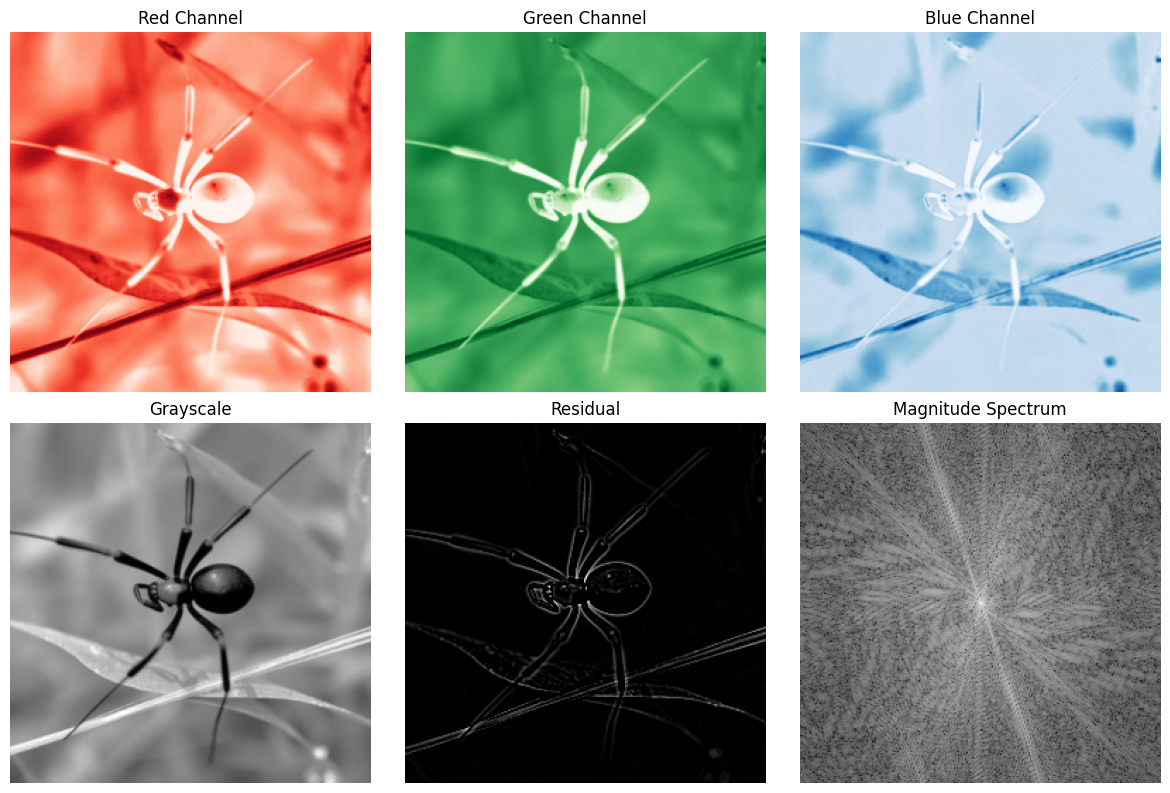

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

image_path = Path('snicket/data/train/midjourney/0002.png')

img = cv2.imread(str(image_path))
b, g, r = cv2.split(img)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
residual = cv2.subtract(gray, blurred)
dft = np.fft.fft2(residual)
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum = 20 * np.log(np.abs(dft_shift) + 1)

plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.title('Red Channel')
plt.imshow(r, cmap='Reds')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.title('Green Channel')
plt.imshow(g, cmap='Greens')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.title('Blue Channel')
plt.imshow(b, cmap='Blues')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.title('Grayscale')
plt.imshow(gray, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.title('Residual')
plt.imshow(residual, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.title('Magnitude Spectrum')
plt.imshow(magnitude_spectrum, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


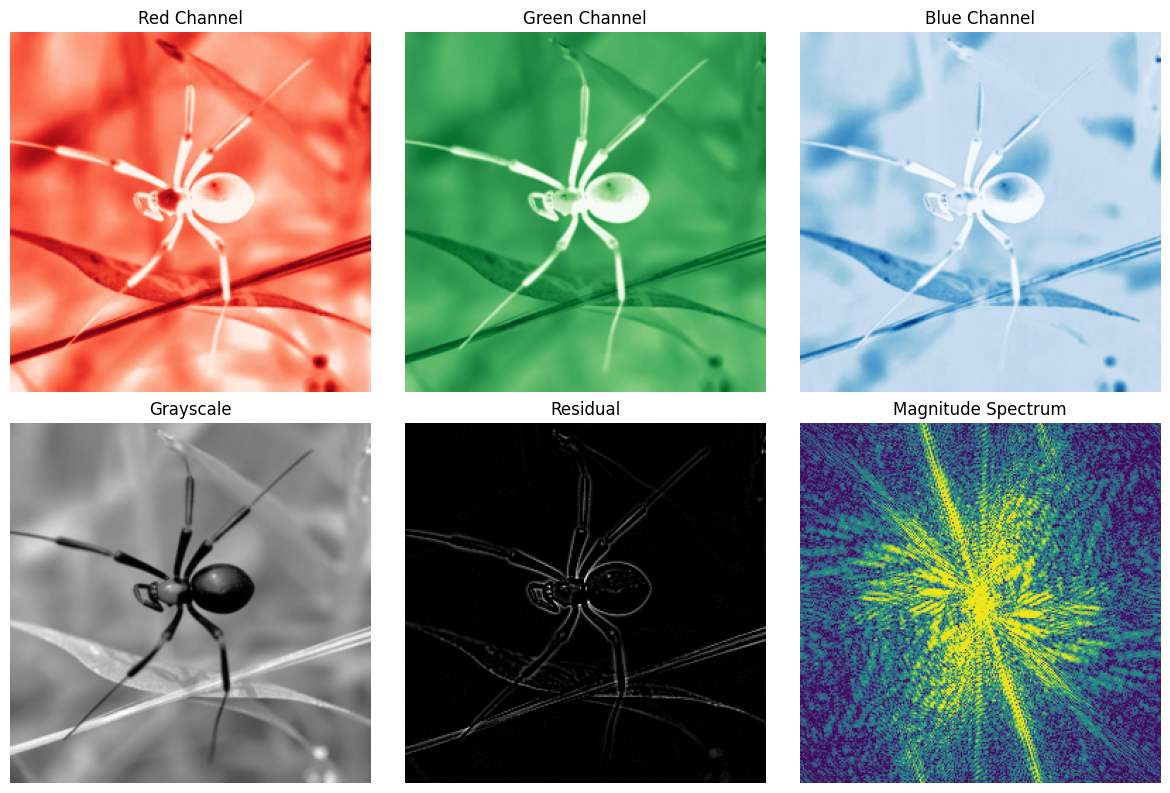

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from pathlib import Path

image_path = Path('snicket/data/train/midjourney/0002.png')
img = cv2.imread(str(image_path))
b, g, r = cv2.split(img)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
residual = cv2.subtract(gray, blurred)

dft = np.fft.fft2(residual)
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum = 20 * np.log(np.abs(dft_shift) + 1)

vmin, vmax = np.percentile(magnitude_spectrum, [10, 95])
norm_spectrum = np.clip((magnitude_spectrum - vmin) / (vmax - vmin), 0, 1)

colors = ['#43085C', '#3B5089', '#1D9C84', '#EFE518']
positions = [0.0, 0.3, 0.7, 1.0]
custom_cmap = LinearSegmentedColormap.from_list("custom", list(zip(positions, colors)))

plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.title('Red Channel')
plt.imshow(r, cmap='Reds')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.title('Green Channel')
plt.imshow(g, cmap='Greens')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.title('Blue Channel')
plt.imshow(b, cmap='Blues')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.title('Grayscale')
plt.imshow(gray, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.title('Residual')
plt.imshow(residual, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.title('Magnitude Spectrum')
plt.imshow(norm_spectrum, cmap=custom_cmap)
plt.axis('off')

plt.tight_layout()
plt.show()


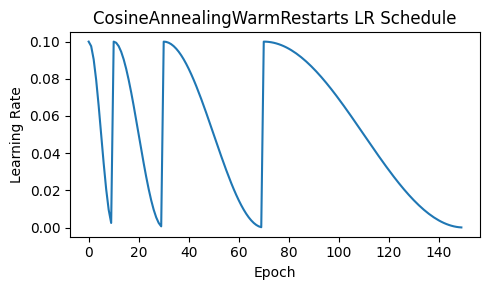

In [9]:
import torch
import matplotlib.pyplot as plt

model = torch.nn.Linear(1, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=10, T_mult=2
)

lrs = []
epochs = 150

for epoch in range(epochs):
    scheduler.step(epoch)
    lrs.append(optimizer.param_groups[0]['lr'])

plt.figure(figsize=(5, 3))
plt.plot(lrs)
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("CosineAnnealingWarmRestarts LR Schedule")
plt.tight_layout()
plt.show()


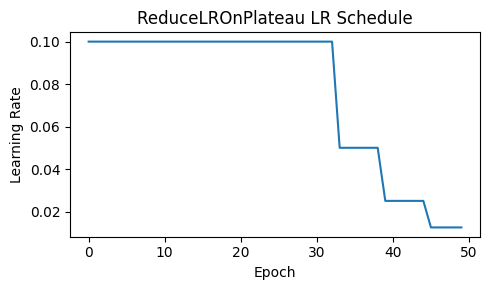

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

model = torch.nn.Linear(1, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, threshold=1e-4
)

epochs = 50
lrs = []
losses = []

np.random.seed(0)
loss = 1.0

for epoch in range(epochs):
    noise = np.random.normal(scale=0.02)
    if epoch < 15:
        loss = loss * 0.95 + noise
    elif epoch < 30:
        loss = loss * 0.99 + noise
    else:
        loss = loss * 1.01 + noise

    losses.append(loss)
    scheduler.step(loss)
    lrs.append(optimizer.param_groups[0]['lr'])

plt.figure(figsize=(5, 3))
plt.plot(lrs)
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("ReduceLROnPlateau LR Schedule")
plt.tight_layout()
plt.show()
